## Imports and functions

In [57]:
import pandas as pd
import numpy as np
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from urllib.parse import urlparse, urlsplit, quote, parse_qs
import tldextract
from tqdm import tqdm
import re
import xgboost as xgb
import warnings
import seaborn as sns
from scipy import stats
from scipy.stats import randint
from sklearn.feature_selection import f_classif, mutual_info_classif
import matplotlib.pyplot as plt
from IPython.display import display

from mlxtend.classifier import EnsembleVoteClassifier


from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Continuous, Categorical, Integer
from sklearn_genetic.plots import plot_fitness_evolution, plot_search_space
from sklearn.model_selection import StratifiedKFold, cross_val_score

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, roc_auc_score, f1_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingRandomSearchCV, HalvingGridSearchCV
#from tune_sklearn import TuneSearchCV
from sklearn.inspection import permutation_importance
#NLP
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

import cupy as cp

import optuna

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import time


In [58]:
def plot_with_values(df):
  ax = df.plot(kind='pie',y='count', legend=True, labels=None, autopct=lambda x: f"{total_rows*x/100000:.1f}k\n({x:.2f})%")
  ax.get_legend().set_bbox_to_anchor((1.1, 1))

_url_pattern = re.compile('(https?://)?(?:www\d?\.)?(?:(?:[0-9]{1,3}\.){3}[0-9]{1,3}|[a-zA-Z0-9.-]+(\.[a-zA-Z]{2,4})+)([^\s]*)')

def clean_non_urls(df):
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Filter out rows that contain URLs
    filtered = df[~df['url'].str.contains(_url_pattern)]
    print(filtered['url'].head().reset_index(drop=True))
    print(filtered.shape[0], 'malformed URLs dropped')
    return df[df['url'].str.contains(_url_pattern)]

In [59]:
def show_results(clf, X_train, y_train, X_test, y_test):
    acc_train = clf.score(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f1_score(y_test, y_pred,pos_label=0))
    display(pd.DataFrame(data=[[acc, acc_train, f1]], columns=['Accuracy', 'Accuracy (Train)', 'F1-Score']).style.hide(axis='index'))
    cm = confusion_matrix(y_test, y_pred)
    
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
    cm_display.plot(cmap='Blues')
    plt.show()

In [60]:
def get_scaled(X_train, X_test):
    global scaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

## Loading and cleanup

In [61]:
df = pd.read_csv('dataset/malicious_phish.csv')

In [62]:
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [63]:
total_rows = df.shape[0]
print(total_rows)

651191


In [64]:
print(df.drop_duplicates().shape[0])

641125


Since there are duplicates, we will drop them

In [65]:
df = df.drop_duplicates()

Now we check for URLs that belong to multiple categories. In this case there are only 6, classified as both phishing and benign. Given the fact that there are two wikipedia articles and a link to yahoo and to make thinks simpler, we will just assign benign to these 6 URLS (even though the first and the last one look suspicious and might be phishing URLs actually)

In [66]:
urls_shared = df.drop_duplicates().groupby('url')['type'].count().reset_index(name='count').query('count > 1')['url']
df[df.url.isin(urls_shared)].groupby('url').agg({'type': set})

,type
url,
ebookstore.sony.com/reader/,"{phishing, benign}"
en.wikipedia.org/wiki/Desktop_publishing,"{phishing, benign}"
en.wikipedia.org/wiki/E-book,"{phishing, benign}"
groups.yahoo.com/group/Band-in-a-Box/,"{phishing, benign}"
memory.loc.gov/ammem/ccmphtml/colahome.html,"{phishing, benign}"
routesinternational.com/air.htm,"{phishing, benign}"


In [67]:
df.loc[df.url.isin(urls_shared), 'type'] = 'benign'

In [68]:
# Define a regular expression pattern to match URLs
df = clean_non_urls(df)

0                               bin/webscr?cmd=_login-
1    wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË\nÓ6...
2                    YìêkoãÕ»Î§DéÎl½ñ¡ââqtò¸/à; Í
3                                     è kvüDâQÎé4¼Ò©
4                                                ¾5092
Name: url, dtype: object
82 malformed URLs dropped


In [69]:
total_rows = df.shape[0]
print(total_rows)

641043


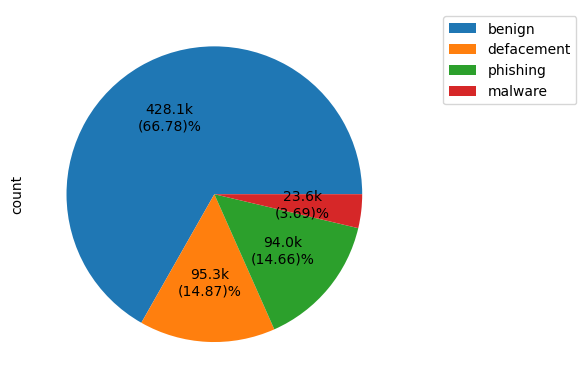

In [70]:
plot_with_values(df.groupby('type')['type'].count().reset_index(name='count').sort_values(['count'], ascending=False).set_index('type'))

In [71]:
df_mw = pd.read_csv('dataset/malware.csv')

In [72]:
df_mw.shape

(42968, 1)

In [73]:
pd.concat([df, df_mw.assign(type='malware')]).drop_duplicates().shape #684011, 14

(683997, 2)

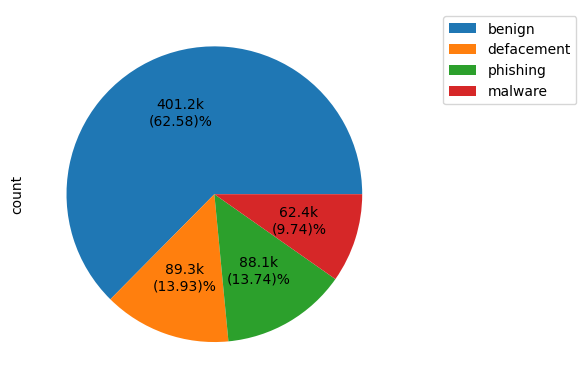

In [74]:
df = pd.concat([df, df_mw.assign(type='malware')]).drop_duplicates().reset_index(drop=True)
plot_with_values(df.groupby('type')['type'].count().reset_index(name='count').sort_values(['count'], ascending=False).set_index('type'))

In [75]:
df

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
683992,http://azmeasurement.com/SWIFT-COPY-MT103-PAYM...,malware
683993,http://livetrack.in/EmployeeMasterImages/qace.jpg,malware
683994,http://123.194.235.37:49320/.i,malware
683995,http://pink99.com/logsite/0LDDOC/TKA1833163913...,malware


In [76]:
total_rows = df.shape[0]
print(total_rows)

683997


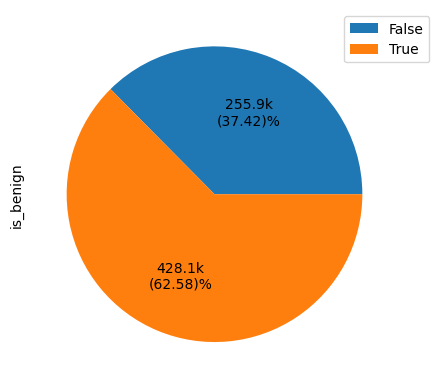

In [77]:
df['is_benign'] = np.where(df['type'] == 'benign', True, False)
plot_with_values(df.groupby('is_benign')['is_benign'].count())

In [78]:
df['url'] = df['url'].str.lower()

In [79]:
df['url'].str[:7].value_counts()

http://    201261
https:/     19653
en.wiki     13428
youtube      8624
faceboo      7850
            ...  
moveina         1
debicha         1
mtsnu-m         1
basetas         1
xbox.vg         1
Name: url, Length: 111413, dtype: int64

In [80]:
df.loc[~df.url.str.startswith('http://') & ~df.url.str.startswith('https://'), 'url'] = 'https://'+df.url

In [81]:
df.loc[df.url.str.startswith('http://www.'), 'url'] = 'http://'+df.url.str.removeprefix('http://www.')
df.loc[df.url.str.startswith('https://www.'), 'url'] = 'https://'+df.url.str.removeprefix('https://www.')

In [82]:
df_c = df.copy()

## Feature Engineering

In [99]:
df['is_https'] = df.url.str.startswith('https')

df['url'].str[:7].value_counts()

https:/    482736
http://    201261
Name: url, dtype: int64

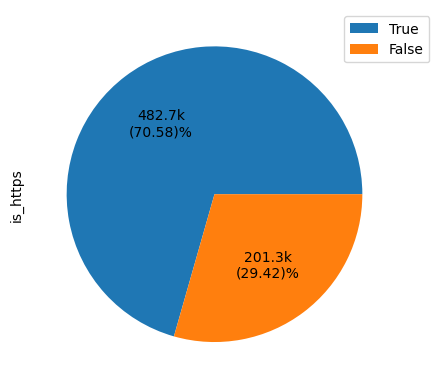

In [100]:
plot_with_values(df['is_https'].value_counts())

In [101]:
df['url_len'] = df['url'].str.len()

In [102]:
df['tld'] = df['url'].map(lambda u: tldextract.extract(u).suffix)

In [103]:
df['tld_len'] = df['tld'].str.len()

In [104]:
df['tld_f'] = df['tld'].str.split('.').str[0]
tld_first = df['tld_f'].value_counts()
#We keep enough TLDs to account for 95% of the dataset
top_tld = tld_first[tld_first.cumsum() / total_rows < 0.95]
df['tld_cat'] = df['tld_f'].where(df['tld_f'].isin(top_tld.index), 'other')
df = df.drop(columns=['tld_f'])


In [105]:
df[df['tld_cat'] == 'other']['tld'].value_counts()

cc           1333
at           1297
cn           1280
se           1258
dk           1213
             ... 
ni.sch.uk       1
dj              1
monster         1
mg.gov.br       1
ma.gov.br       1
Name: tld, Length: 602, dtype: int64

In [106]:
top_tld.to_frame(name='count')

,count
com,415662
org,53091
,50028
net,29520
co,14363
de,13522
edu,10921
ca,9499
nl,7084
ru,5431


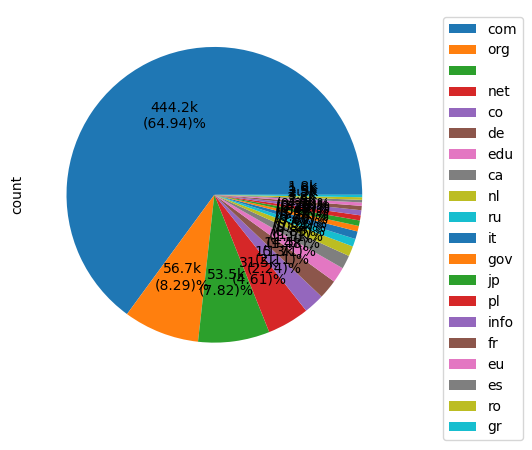

In [107]:
plot_with_values(top_tld.to_frame(name='count').rename(columns={'tld': 'count'}).rename_axis('tld').head(20))

In [108]:
df.groupby(['type', 'tld'])[['url']].count().sort_values(['type', 'url'], ascending=False).groupby(level=0).head(4)

url
type       tld           
phishing   com      49391
           org       9439
           net       5460
           edu       3140
malware             49664
           com       8838
           jp        2910
           info       508
defacement com      29153
           de       10768
           nl        5998
           com.br    4517
benign     com     309357
           org      37535
           net      18989
           ca        8434

In [109]:
df[df['tld'] == ''][['url']].head()

,url
5704,https://77.228.191.183:7674/zeujuus/a/modules/...
10371,http://219.232.244.89/intl/update/error_login.htm
14848,http://66.208.115.70/images/index.asp
15835,http://107.21.154.157/recordings/locale/.../my...
22112,https://216.92.161.171/vb/printthread.php?t=84...


In [110]:
df['url_parse_object'] = df['url'].apply(urlparse)

In [111]:
re_ip = re.compile('\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$')
df['is_ip']=df['url_parse_object'].apply(lambda u: bool(re_ip.match(u.hostname)))

In [112]:
df['non_ascii']=~df.url.map(str.isascii)

In [113]:
df['n_domains']=df['url_parse_object'].apply(lambda u: u.hostname.count('.'))

In [114]:
df['n_dirs']=df['url_parse_object'].apply(lambda u: u.path.count('/'))

In [115]:
df['port'] = df['url_parse_object'].apply(lambda u: u.port or 0)

In [116]:
df['path_len'] = df['url_parse_object'].apply(lambda u: len(u.path))

In [117]:
df['hostname_len'] = df['url_parse_object'].apply(lambda u: len(u.hostname))

In [118]:
df['has_fragment'] = df['url_parse_object'].apply(lambda u: u.fragment != '')

In [119]:
df['n_query_arguments'] = df['url_parse_object'].apply(lambda u: u.query.count('&'))

In [120]:
df['n_digits'] = df['url'].apply(lambda s: sum(c.isdigit() for c in s))

In [121]:
df = df.replace({False: 0, True: 1})

In [122]:
df_o = df.copy()

```python
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df["type_code"] = lb_make.fit_transform(df["type"])
df["type_code"].value_counts()
```

## Training

### Unused Staff

In [220]:
#df_n = df.select_dtypes(include=['number'])

In [221]:
#df_n.describe().T

In [222]:
#target_var = 'type'

In [223]:
"""featureNames = df_n.drop(target_var,axis=1).columns
# do calculations
y = df_n[[target_var]]
X = df_n.drop(target_var,axis=1)
f_test, _ = f_classif(X, y)
f_test /= np.max(f_test)
mi = mutual_info_classif(X, y)"""

'featureNames = df_n.drop(target_var,axis=1).columns\n# do calculations\ny = df_n[[target_var]]\nX = df_n.drop(target_var,axis=1)\nf_test, _ = f_classif(X, y)\nf_test /= np.max(f_test)\nmi = mutual_info_classif(X, y)'

In [224]:
"""plt.figure(figsize=(30, 5))
plt.subplot(1,2,1)
plt.bar(range(X.shape[1]), f_test, align="center")
plt.xticks(range(X.shape[1]), featureNames)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$F-test$ score')
plt.subplot(1,2,2)
plt.bar(range(X.shape[1]),mi, align="center")
plt.xticks(range(X.shape[1]),featureNames)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')
plt.show()"""

'plt.figure(figsize=(30, 5))\nplt.subplot(1,2,1)\nplt.bar(range(X.shape[1]), f_test, align="center")\nplt.xticks(range(X.shape[1]), featureNames)\nplt.xlabel(\'features\')\nplt.ylabel(\'Ranking\')\nplt.title(\'$F-test$ score\')\nplt.subplot(1,2,2)\nplt.bar(range(X.shape[1]),mi, align="center")\nplt.xticks(range(X.shape[1]),featureNames)\nplt.xlabel(\'features\')\nplt.ylabel(\'Ranking\')\nplt.title(\'Mutual information score\')\nplt.show()'

In [225]:
#df_graph = df_n[(df_n < df_n.quantile(0.99)).all(axis=1)]

In [226]:
"""df_n = df_n.join(df[['type']])
df_graph = df_graph.join(df[['type', 'is_benign']])"""

"df_n = df_n.join(df[['type']])\ndf_graph = df_graph.join(df[['type', 'is_benign']])"

In [227]:
#df_graph = df_graph.groupby('is_benign').apply(lambda g: g.sample(10000))

In [228]:
"""# Set up subplots
n_cols = 2
n_rows = (len(df_graph.columns)) // 2  # Add 1 for the last row if odd

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 8))

# Flatten axes to handle both odd and even numbers of columns
axes = axes.flatten()

# Loop through numerical columns and create histograms
for i, col in enumerate(df_graph.drop(['is_benign', 'type'], axis=1, errors='ignore').columns):
    ax = axes[i]

    # Separate data by 'is_benign' column
    benign_data = df_graph[df_graph['is_benign']][col]
    malignant_data = df_graph[~df_graph['is_benign']][col]

    # Plot histograms with different colors
    ax.hist(benign_data, bins=20, alpha=0.5, color='green', label='Benign')
    ax.hist(malignant_data, bins=20, alpha=0.5, color='red', label='Malignant')

    ax.set_title(col)
    ax.legend()

# Hide empty subplots (if any)
for i in range(len(df_graph.drop(['is_benign', 'type'], axis=1, errors='ignore').columns), n_rows * n_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()"""

"# Set up subplots\nn_cols = 2\nn_rows = (len(df_graph.columns)) // 2  # Add 1 for the last row if odd\n\nfig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 8))\n\n# Flatten axes to handle both odd and even numbers of columns\naxes = axes.flatten()\n\n# Loop through numerical columns and create histograms\nfor i, col in enumerate(df_graph.drop(['is_benign', 'type'], axis=1, errors='ignore').columns):\n    ax = axes[i]\n\n    # Separate data by 'is_benign' column\n    benign_data = df_graph[df_graph['is_benign']][col]\n    malignant_data = df_graph[~df_graph['is_benign']][col]\n\n    # Plot histograms with different colors\n    ax.hist(benign_data, bins=20, alpha=0.5, color='green', label='Benign')\n    ax.hist(malignant_data, bins=20, alpha=0.5, color='red', label='Malignant')\n\n    ax.set_title(col)\n    ax.legend()\n\n# Hide empty subplots (if any)\nfor i in range(len(df_graph.drop(['is_benign', 'type'], axis=1, errors='ignore').columns), n_rows * n_cols):\n    fig.de

### Prepare and split dataset for training

In [50]:
df_n = pd.get_dummies(df.select_dtypes(include=['number']).astype('float32').join(df[['tld_cat']]), columns=['tld_cat'])

In [51]:
feature_names = df_n.drop('is_benign',axis=1).columns

In [52]:
y = df_n[['is_benign']].values.ravel()
X = df_n.drop('is_benign',axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 99)

In [53]:
X_train_scaled, X_test_scaled = get_scaled(X_train, X_test)

### Logistic Regression

In [65]:
logisticRegr = LogisticRegression(solver='saga')
logisticRegr.fit(X_train_scaled, y_train)

LogisticRegression(solver='saga')

Accuracy,Accuracy (Train),F1-Score
0.675658,0.675499,0.794074


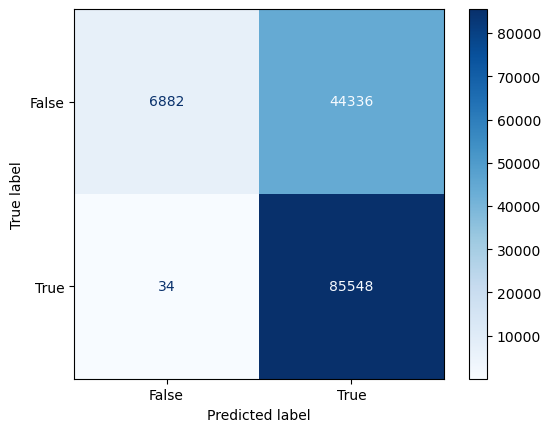

In [66]:
show_results(logisticRegr, X_train, y_train, X_test, y_test)

### Random Forest

In [76]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1500),
        'max_features': trial.suggest_float('max_features', 0.3, 1.0),
        "max_depth": trial.suggest_int("max_depth", 2, 100),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
    }
    model = RandomForestClassifier(**params, n_jobs=-1)
    
    #Training the model on the training data
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy')
    accuracy = score.mean()
    return accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10, n_jobs=1)
print(study.best_trial)

[I 2023-10-27 17:22:54,692] A new study created in memory with name: no-name-44012196-6fe9-41df-b3b8-5544c8a9a62a
[I 2023-10-27 17:26:25,140] Trial 0 finished with value: 0.9361016233641632 and parameters: {'n_estimators': 1242, 'max_features': 0.5989023109242969, 'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.9361016233641632.
[I 2023-10-27 17:27:56,331] Trial 1 finished with value: 0.9357543992383 and parameters: {'n_estimators': 727, 'max_features': 0.3827645764425881, 'max_depth': 21, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.9361016233641632.
[I 2023-10-27 17:32:20,605] Trial 2 finished with value: 0.9381374532389616 and parameters: {'n_estimators': 1500, 'max_features': 0.5974319440504214, 'max_depth': 56, 'min_samples_split': 18, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.9381374532389616.
[I 2023-10-27 17:36:23,990] Trial 3 finished with value: 0.9364342275268323 and parameters: {'n_e

FrozenTrial(number=2, state=TrialState.COMPLETE, values=[0.9381374532389616], datetime_start=datetime.datetime(2023, 10, 27, 17, 27, 56, 331841), datetime_complete=datetime.datetime(2023, 10, 27, 17, 32, 20, 605114), params={'n_estimators': 1500, 'max_features': 0.5974319440504214, 'max_depth': 56, 'min_samples_split': 18, 'min_samples_leaf': 1}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1500, log=False, low=200, step=1), 'max_features': FloatDistribution(high=1.0, log=False, low=0.3, step=None), 'max_depth': IntDistribution(high=100, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=20, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1)}, trial_id=2, value=None)


In [54]:
%%time
params={
    'n_estimators': 1500, 
    'max_features': 0.5974319440504214, 
    'max_depth': 56, 
    'min_samples_split': 18, 
    'min_samples_leaf': 1
}
rf = RandomForestClassifier(**params, n_jobs=-1)
rf.fit(X_train, y_train)

CPU times: user 50min 10s, sys: 3.07 s, total: 50min 14s
Wall time: 3min 9s


RandomForestClassifier(max_depth=56, max_features=0.5974319440504214,
                       min_samples_split=18, n_estimators=1500, n_jobs=-1)

0.915486906710311


Accuracy,Accuracy (Train),F1-Score
0.939605,0.950100,0.953014


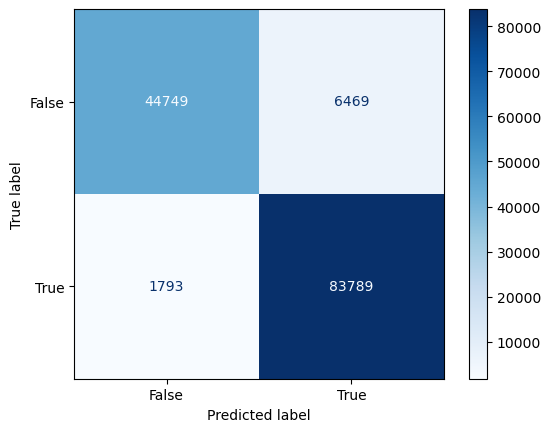

In [151]:
show_results(rf, X_train, y_train, X_test, y_test)

### Cuml Random Forest

In [59]:
from cuml import RandomForestClassifier as Cuml_RFC
from sklearn.ensemble import RandomForestClassifier

In [60]:
%%time
cu_rf_params = {
    'n_estimators': 600, 
    'n_bins': 91, 
    'min_samples_split': 10, 
    'min_samples_leaf': 1, 
    'max_features': 1.0, 
    'max_depth': 60,
    'n_streams': 8
}
rf = Cuml_RFC(**cu_rf_params)
rf.fit(X_train, y_train)

CPU times: user 56.9 s, sys: 1min 2s, total: 1min 59s
Wall time: 26.6 s


RandomForestClassifier()

In [61]:
rf.score(X_test, y_test)

0.9389473795890808

In [ ]:
import time

import numpy as np

start_time = time.time()
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

In [ ]:
len(feature_names)

In [ ]:
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [63]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['sqrt', 1.0, 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
n_bins = [int(x) for x in np.linspace(10, 200, num = 15)]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'n_bins': n_bins}

In [ ]:
rf = Cuml_RFC(n_streams= 20)
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, cv = 3, verbose=2, n_iter=20, random_state=42,  n_jobs = 1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_bins=64, n_estimators=1200; total time=  15.5s
[CV] END max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_bins=64, n_estimators=1200; total time=  15.2s
[CV] END max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_bins=64, n_estimators=1200; total time=  15.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_bins=159, n_estimators=200; total time=   2.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_bins=159, n_estimators=200; total time=   2.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_bins=159, n_estimators=200; total time=   2.0s
[CV] END max_depth=100, max_features=1.0, min_samples_leaf=1, min_samples_split=10, n_bins=77, n_estimators=1800; total time=  45.3s
[CV] END ma

In [ ]:
print(rf_random.best_params_)

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int("n_estimators", 200, 1000),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 1.0, 'log2']),
        'max_depth': trial.suggest_int("max_depth", 10, 110),
        'min_samples_split': trial.suggest_int("min_samples_split", 2, 15),
        'min_samples_leaf': trial.suggest_int("min_samples_leaf", 1, 7),
        'n_bins': trial.suggest_int("n_bins", 10, 200)
    }
    model = Cuml_RFC(**params)
    
    #Training the model on the training data
    model.fit(X_train, y_train)
    
    #Making predictions on the test set
    predictions = model.predict(X_test)
    
    #Calculating accuracy
    accuracy = accuracy_score(y_test, predictions)
    return accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, n_jobs=1)
print(study.best_trial)

[I 2023-10-25 19:24:12,934] A new study created in memory with name: no-name-d4a81a91-999e-4de9-bbff-608e9927d8e5
[I 2023-10-25 19:24:20,376] Trial 0 finished with value: 0.8602046783625731 and parameters: {'n_estimators': 325, 'max_features': 'sqrt', 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 4, 'n_bins': 50}. Best is trial 0 with value: 0.8602046783625731.
[I 2023-10-25 19:24:40,696] Trial 1 finished with value: 0.8566154970760234 and parameters: {'n_estimators': 879, 'max_features': 'log2', 'max_depth': 48, 'min_samples_split': 8, 'min_samples_leaf': 6, 'n_bins': 118}. Best is trial 0 with value: 0.8602046783625731.
[I 2023-10-25 19:24:51,368] Trial 2 finished with value: 0.8593201754385965 and parameters: {'n_estimators': 454, 'max_features': 'log2', 'max_depth': 70, 'min_samples_split': 15, 'min_samples_leaf': 1, 'n_bins': 64}. Best is trial 0 with value: 0.8602046783625731.
[I 2023-10-25 19:25:14,034] Trial 3 finished with value: 0.8628947368421053 and parameter

### Decision Tree

In [138]:
# Number of features to consider at every split
max_features = ['sqrt', None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [ ]:
%%time
clf = DecisionTreeClassifier(random_state=42)
cv = GridSearchCV(clf, random_grid, cv=3, verbose=1)
cv.fit(X_train, y_train)

In [ ]:
print(cv.best_params_)

In [146]:
from optuna.samplers import NSGAIISampler

In [149]:
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 2, 30),
        "max_features": trial.suggest_float("max_features", 0.2, 1.0),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 15)
    }
    model = DecisionTreeClassifier(**params)
    
    #Training the model on the training data
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=lambda estimator, X, y: f1_score(y, estimator.predict(X), pos_label=0))
    accuracy = score.mean()
    return accuracy


study = optuna.create_study(direction="maximize", sampler= NSGAIIISampler())
study.optimize(objective, n_trials=20, n_jobs=-1)
print(study.best_trial)

/tmp/ipykernel_2814/126072684.py:16: ExperimentalWarning: NSGAIIISampler is experimental (supported from v3.2.0). The interface can change in the future.
  study = optuna.create_study(direction="maximize", sampler= NSGAIIISampler())
[I 2023-10-30 14:17:27,178] A new study created in memory with name: no-name-61e77bc6-1ac4-4db6-a5e0-434067647e04
[I 2023-10-30 14:17:33,121] Trial 11 finished with value: 0.7886987428524355 and parameters: {'max_depth': 6, 'max_features': 0.32186593142726727, 'min_samples_split': 7, 'min_samples_leaf': 7}. Best is trial 11 with value: 0.7886987428524355.
[I 2023-10-30 14:17:34,481] Trial 15 finished with value: 0.890032454946548 and parameters: {'max_depth': 26, 'max_features': 0.23100109426176374, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 15 with value: 0.890032454946548.
[I 2023-10-30 14:17:35,171] Trial 7 finished with value: 0.8825540838875151 and parameters: {'max_depth': 14, 'max_features': 0.2918443725107396, 'min_samples_split':

FrozenTrial(number=3, state=TrialState.COMPLETE, values=[0.9041299252203172], datetime_start=datetime.datetime(2023, 10, 30, 14, 17, 27, 185297), datetime_complete=datetime.datetime(2023, 10, 30, 14, 17, 42, 460279), params={'max_depth': 28, 'max_features': 0.7973826805883555, 'min_samples_split': 5, 'min_samples_leaf': 5}, user_attrs={}, system_attrs={'nsga3:generation': 0}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=30, log=False, low=2, step=1), 'max_features': FloatDistribution(high=1.0, log=False, low=0.2, step=None), 'min_samples_split': IntDistribution(high=20, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=15, log=False, low=1, step=1)}, trial_id=3, value=None)


In [55]:
%%time
clf_dt = DecisionTreeClassifier(max_depth=30, min_samples_split= 10, min_samples_leaf= 4, random_state = 42)

clf_dt.fit(X_train, y_train)

CPU times: user 2.33 s, sys: 0 ns, total: 2.33 s
Wall time: 2.33 s


DecisionTreeClassifier(max_depth=30, min_samples_leaf=4, min_samples_split=10,
                       random_state=42)

0.8743213790370516


Accuracy,Accuracy (Train),F1-Score
0.907266,0.945782,0.926526


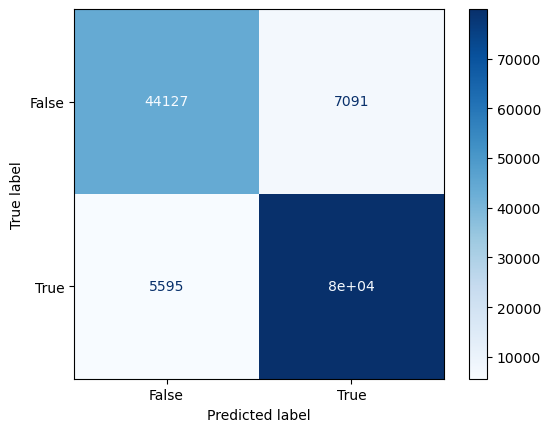

In [113]:
show_results(clf_dt, X_train, y_train, X_test, y_test)

### SVM

In [63]:
from cuml.svm import SVC as CU_SVC, LinearSVC
from sklearn.svm import SVC

In [78]:
import optuna

In [ ]:
def objective(trial):
    params = {
        "C": trial.suggest_float('C', 1e-10, 1e10, log=True),
        "gamma": trial.suggest_categorical("gamma", ["auto", "scale"]),
        "cache_size": 5000
    }
    model = CU_SVC(**params)
    
    #Training the model on the training data
    model.fit(X_train_scaled, y_train)
    
    #Making predictions on the test set
    predictions = model.predict(X_test_scaled)
    
    #Calculating accuracy
    accuracy = accuracy_score(y_test, predictions)
    return accuracy
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print(study.best_trial)

In [ ]:
%%time
clf_sv = SVC(C = 21, )

clf_sv.fit(X_train_scaled, y_train)

In [ ]:
show_results(clf_sv, X_train_scaled, y_train, X_test_scaled, y_test)

### XGBoost

Normal accuracy optimize

In [150]:
def objective(trial):
    params = {
        "objective": 'binary:logistic',
        "n_estimators": trial.suggest_int("n_estimators", 200, 1500),
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 30),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20)
    }
    model = xgb.XGBClassifier(**params, n_jobs=-1)
    
    #Training the model on the training data
    score = cross_val_score(model, X_train, y_train, cv=5)
    accuracy = score.mean()
    return accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, n_jobs=1)
print(study.best_trial)

/tmp/ipykernel_2814/3949065201.py:20: ExperimentalWarning: NSGAIIISampler is experimental (supported from v3.2.0). The interface can change in the future.
  study = optuna.create_study(direction="maximize", sampler= NSGAIIISampler())
[I 2023-10-30 14:19:55,924] A new study created in memory with name: no-name-211ce428-1e94-4649-9d82-e8f9fe5cc8e1
[I 2023-10-30 14:22:53,363] Trial 0 finished with value: 0.9268197759229968 and parameters: {'n_estimators': 279, 'learning_rate': 0.0005592521594079302, 'max_depth': 15, 'subsample': 0.6307978884128622, 'colsample_bytree': 0.6726631875017308, 'min_child_weight': 6}. Best is trial 0 with value: 0.9268197759229968.
[W 2023-10-30 14:24:07,930] Trial 1 failed with parameters: {'n_estimators': 760, 'learning_rate': 0.02709147873870592, 'max_depth': 3, 'subsample': 0.6654514040245237, 'colsample_bytree': 0.246947006844482, 'min_child_weight': 18} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/al

KeyboardInterrupt: 

In [153]:
def objective(trial):
    params = {
        "objective": 'binary:logistic',
        "n_estimators": trial.suggest_int("n_estimators", 200, 1500),
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 30),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20)
    }
    model = xgb.XGBClassifier(**params, n_jobs=-1)
    
    #Training the model on the training data
    score = cross_val_score(model, X_train, y_train, cv=3, scoring=lambda estimator, X, y: f1_score(y, estimator.predict(X), pos_label=0))
    accuracy = score.mean()
    return accuracy


study = optuna.create_study(direction="maximize", sampler= NSGAIIISampler() )
study.optimize(objective, n_trials=20, n_jobs=1)
print(study.best_trial)

/tmp/ipykernel_2814/3278371791.py:20: ExperimentalWarning: NSGAIIISampler is experimental (supported from v3.2.0). The interface can change in the future.
  study = optuna.create_study(direction="maximize", sampler= NSGAIIISampler() )
[I 2023-10-30 14:26:29,443] A new study created in memory with name: no-name-1bd3364c-f6e6-4b3f-a92c-f582537b4876
[I 2023-10-30 14:30:49,177] Trial 0 finished with value: 0.9114707629266731 and parameters: {'n_estimators': 1422, 'learning_rate': 0.07815954270474128, 'max_depth': 20, 'subsample': 0.8251613656851579, 'colsample_bytree': 0.23487382309953342, 'min_child_weight': 6}. Best is trial 0 with value: 0.9114707629266731.
[I 2023-10-30 14:32:08,312] Trial 1 finished with value: 0.8615707671549527 and parameters: {'n_estimators': 363, 'learning_rate': 0.0004404767125476772, 'max_depth': 22, 'subsample': 0.16213787112247774, 'colsample_bytree': 0.48243827083164564, 'min_child_weight': 17}. Best is trial 0 with value: 0.9114707629266731.
[I 2023-10-30 14

FrozenTrial(number=10, state=TrialState.COMPLETE, values=[0.912999837337562], datetime_start=datetime.datetime(2023, 10, 30, 15, 10, 37, 37301), datetime_complete=datetime.datetime(2023, 10, 30, 15, 20, 31, 333351), params={'n_estimators': 1131, 'learning_rate': 0.08527408660150722, 'max_depth': 23, 'subsample': 0.6575355299530418, 'colsample_bytree': 0.9286215055797209, 'min_child_weight': 16}, user_attrs={}, system_attrs={'nsga3:generation': 0}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1500, log=False, low=200, step=1), 'learning_rate': FloatDistribution(high=0.1, log=True, low=1e-05, step=None), 'max_depth': IntDistribution(high=30, log=False, low=2, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.05, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.2, step=None), 'min_child_weight': IntDistribution(high=20, log=False, low=1, step=1)}, trial_id=10, value=None)


In [ ]:
param_grid = {
              "learning_rate":Continuous(1e-5, 0.1, distribution='log-uniform'),
              'max_depth': Integer(2, 30),
              "subsample": Continuous(0.05, 1.0),
              "colsample_bytree": Continuous(0.2, 1.0),
              "min_child_weight": Integer(1, 20),
              'n_estimators': Integer(200, 1000),}
              
clf = xgb.XGBClassifier(objective='binary:logistic',)
cv = StratifiedKFold(n_splits=3, shuffle=True)

evolved_estimator = GASearchCV(estimator=clf,
                               cv=cv,
                               scoring='accuracy',
                               population_size=10,
                               generations=35,
                               tournament_size=3,
                               elitism=True,
                               crossover_probability=0.8,
                               mutation_probability=0.1,
                               param_grid=param_grid,
                               criteria='max',
                               algorithm='eaMuPlusLambda',
                               n_jobs=-1,
                               verbose=True,
                               keep_top_k=4)

evolved_estimator.fit(X_train,y_train)
y_predicy_ga = evolved_estimator.predict(X_test)
accuracy_score(y_test,y_predicy_ga)

In [ ]:
plot_fitness_evolution(evolved_estimator)
plt.show()

In [ ]:
evolved_estimator.best_params

In [56]:
%%time
"""params = {
    "objective": 'binary:logistic',
    "device": "cuda",
    'n_estimators': 1094, 
     'learning_rate': 0.07150102198263987, 
     'max_depth': 30, 
     'subsample': 0.9973996696538996, 
     'colsample_bytree': 0.44006587339793746, 
     'min_child_weight': 7,
    "silent": 1
}
"""
params={'n_estimators': 786, 'learning_rate': 0.013720903052523744, 'max_depth': 19, 'subsample': 0.6573560376366206, 'colsample_bytree': 0.7567602206751921, 'min_child_weight': 3}
clf_xgb = xgb.XGBClassifier(**params, verbosity=0,verbose_eval= 0,n_jobs=-1)

#Training the model on the training data
clf_xgb.fit(X_train, y_train)

CPU times: user 41min 44s, sys: 2.86 s, total: 41min 47s
Wall time: 2min 38s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7567602206751921, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.013720903052523744,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=19, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=786, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

0.9158123513491346


Accuracy,Accuracy (Train),F1-Score
0.939971,0.948525,0.953356


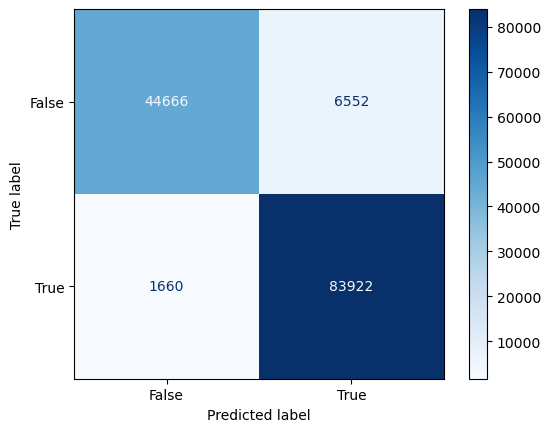

In [153]:
show_results(clf_xgb, X_train, y_train, X_test, y_test)

### Light GBM

In [102]:
import optuna.integration.lightgbm as lgb_opt

from lightgbm import early_stopping
from lightgbm import log_evaluation
from sklearn.model_selection import KFold


if __name__ == "__main__":
    dtrain = lgb_opt.Dataset(X_train, label=y_train)

    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
    }

    tuner = lgb_opt.LightGBMTunerCV(
        params,
        dtrain,
        folds=KFold(n_splits=3),
        callbacks=[early_stopping(100), log_evaluation(100)],
    )

    tuner.run()

    print("Best score:", tuner.best_score)
    best_params = tuner.best_params
    print("Best params:", best_params)
    print("  Params: ")
    for key, value in best_params.items():
        print("    {}: {}".format(key, value))

[I 2023-10-26 00:20:25,628] A new study created in memory with name: no-name-d8d7cd31-03c1-4dda-8bf2-37e067e8e433
feature_fraction, val_score: inf:   0%|                                                           | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.199714 + 0.00103206
[200]	cv_agg's valid binary_logloss: 0.188071 + 0.00105423
[300]	cv_agg's valid binary_logloss: 0.181431 + 0.00120304
[400]	cv_agg's valid binary_logloss: 0.177011 + 0.000884537
[500]	cv_agg's valid binary_logloss: 0.173965 + 0.000786354
[600]	cv_agg's valid binary_logloss: 0.171541 + 0.00119722
[700]	cv_agg's valid binary_logloss: 0.169646 + 0.00116127
[800]	cv_agg's valid binary_logloss: 0.167956 + 0.00119171
[900]	cv_agg's valid binary_logloss: 0.166814 + 0.00124087


feature_fraction, val_score: 0.165732:  14%|######5                                       | 1/7 [00:09<00:58,  9.76s/it]

[1000]	cv_agg's valid binary_logloss: 0.165732 + 0.00126046
Did not meet early stopping. Best iteration is:
[1000]	cv_agg's valid binary_logloss: 0.165732 + 0.00126046
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.19959 + 0.00104144
[200]	cv_agg's valid binary_logloss: 0.187725 + 0.00144978
[300]	cv_agg's valid binary_logloss: 0.181268 + 0.00147219
[400]	cv_agg's valid binary_logloss: 0.176505 + 0.0013533
[500]	cv_agg's valid binary_logloss: 0.173412 + 0.0013474
[600]	cv_agg's valid binary_logloss: 0.170928 + 0.00139968
[700]	cv_agg's valid binary_logloss: 0.169013 + 0.00129891
[800]	cv_agg's valid binary_logloss: 0.167398 + 0.00150311
[900]	cv_agg's valid binary_logloss: 0.166028 + 0.00140557


feature_fraction, val_score: 0.165008:  29%|#############1                                | 2/7 [00:19<00:48,  9.74s/it]

[1000]	cv_agg's valid binary_logloss: 0.165008 + 0.00150994
Did not meet early stopping. Best iteration is:
[1000]	cv_agg's valid binary_logloss: 0.165008 + 0.00150994
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.200622 + 0.00140867
[200]	cv_agg's valid binary_logloss: 0.188568 + 0.0011474
[300]	cv_agg's valid binary_logloss: 0.182045 + 0.00093004
[400]	cv_agg's valid binary_logloss: 0.177723 + 0.00120334
[500]	cv_agg's valid binary_logloss: 0.174703 + 0.00119581
[600]	cv_agg's valid binary_logloss: 0.172236 + 0.00124139
[700]	cv_agg's valid binary_logloss: 0.170231 + 0.00114031
[800]	cv_agg's valid binary_logloss: 0.168508 + 0.00125782
[900]	cv_agg's valid binary_logloss: 0.167275 + 0.00150224


feature_fraction, val_score: 0.165008:  43%|###################7                          | 3/7 [00:29<00:40, 10.09s/it]

[1000]	cv_agg's valid binary_logloss: 0.166256 + 0.00150471
Did not meet early stopping. Best iteration is:
[1000]	cv_agg's valid binary_logloss: 0.166256 + 0.00150471
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.213536 + 0.00092742
[200]	cv_agg's valid binary_logloss: 0.193677 + 0.000957728
[300]	cv_agg's valid binary_logloss: 0.187504 + 0.00096733
[400]	cv_agg's valid binary_logloss: 0.183227 + 0.00109615
[500]	cv_agg's valid binary_logloss: 0.179863 + 0.00117963
[600]	cv_agg's valid binary_logloss: 0.177483 + 0.00108678
[700]	cv_agg's valid binary_logloss: 0.175515 + 0.00118172
[800]	cv_agg's valid binary_logloss: 0.174111 + 0.00125546
[900]	cv_agg's valid binary_logloss: 0.172833 + 0.00123963


feature_fraction, val_score: 0.165008:  57%|##########################2                   | 4/7 [00:43<00:34, 11.43s/it]

[1000]	cv_agg's valid binary_logloss: 0.171865 + 0.0013109
Did not meet early stopping. Best iteration is:
[1000]	cv_agg's valid binary_logloss: 0.171865 + 0.0013109
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.205228 + 0.000920385
[200]	cv_agg's valid binary_logloss: 0.191007 + 0.00114826
[300]	cv_agg's valid binary_logloss: 0.184853 + 0.00171843
[400]	cv_agg's valid binary_logloss: 0.180775 + 0.00140981
[500]	cv_agg's valid binary_logloss: 0.177377 + 0.00126071
[600]	cv_agg's valid binary_logloss: 0.174918 + 0.00138869
[700]	cv_agg's valid binary_logloss: 0.173017 + 0.00148241
[800]	cv_agg's valid binary_logloss: 0.171664 + 0.00135914
[900]	cv_agg's valid binary_logloss: 0.170524 + 0.00129596


feature_fraction, val_score: 0.165008:  71%|################################8             | 5/7 [00:55<00:23, 11.78s/it]

[1000]	cv_agg's valid binary_logloss: 0.169376 + 0.00129555
Did not meet early stopping. Best iteration is:
[1000]	cv_agg's valid binary_logloss: 0.169376 + 0.00129555
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.1992 + 0.00116487
[200]	cv_agg's valid binary_logloss: 0.187901 + 0.001169
[300]	cv_agg's valid binary_logloss: 0.181104 + 0.000906279
[400]	cv_agg's valid binary_logloss: 0.176458 + 0.000982962
[500]	cv_agg's valid binary_logloss: 0.173326 + 0.0011201
[600]	cv_agg's valid binary_logloss: 0.170886 + 0.00111118
[700]	cv_agg's valid binary_logloss: 0.168872 + 0.00129735
[800]	cv_agg's valid binary_logloss: 0.167315 + 0.00156562
[900]	cv_agg's valid binary_logloss: 0.16616 + 0.00143247


feature_fraction, val_score: 0.164991:  86%|#######################################4      | 6/7 [01:07<00:11, 11.57s/it]

[1000]	cv_agg's valid binary_logloss: 0.164991 + 0.00141387
Did not meet early stopping. Best iteration is:
[1000]	cv_agg's valid binary_logloss: 0.164991 + 0.00141387
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.201788 + 0.00122284
[200]	cv_agg's valid binary_logloss: 0.189254 + 0.00129031
[300]	cv_agg's valid binary_logloss: 0.183003 + 0.00127647
[400]	cv_agg's valid binary_logloss: 0.178511 + 0.000974367
[500]	cv_agg's valid binary_logloss: 0.175572 + 0.000868913
[600]	cv_agg's valid binary_logloss: 0.173201 + 0.000817125
[700]	cv_agg's valid binary_logloss: 0.171397 + 0.0010109
[800]	cv_agg's valid binary_logloss: 0.169851 + 0.000938548
[900]	cv_agg's valid binary_logloss: 0.168559 + 0.00107451


feature_fraction, val_score: 0.164991: 100%|##############################################| 7/7 [01:22<00:00, 11.81s/it]


[1000]	cv_agg's valid binary_logloss: 0.167541 + 0.00124789
Did not meet early stopping. Best iteration is:
[1000]	cv_agg's valid binary_logloss: 0.167541 + 0.00124789


num_leaves, val_score: 0.164991:   0%|                                                           | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.186419 + 0.00112699
[200]	cv_agg's valid binary_logloss: 0.177219 + 0.00115472
[300]	cv_agg's valid binary_logloss: 0.171643 + 0.000823025
[400]	cv_agg's valid binary_logloss: 0.168501 + 0.000784397
[500]	cv_agg's valid binary_logloss: 0.166232 + 0.000945701
[600]	cv_agg's valid binary_logloss: 0.164251 + 0.000869642
[700]	cv_agg's valid binary_logloss: 0.162744 + 0.00098202
[800]	cv_agg's valid binary_logloss: 0.161622 + 0.00108325
[900]	cv_agg's valid binary_logloss: 0.160845 + 0.00138792


num_leaves, val_score: 0.160385:   5%|##5                                                | 1/20 [00:12<03:57, 12.52s/it]

[1000]	cv_agg's valid binary_logloss: 0.160385 + 0.00136355
Did not meet early stopping. Best iteration is:
[1000]	cv_agg's valid binary_logloss: 0.160385 + 0.00136355
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.164013 + 0.0010352
[200]	cv_agg's valid binary_logloss: 0.159148 + 0.00127721
[300]	cv_agg's valid binary_logloss: 0.157582 + 0.00140183
[400]	cv_agg's valid binary_logloss: 0.157324 + 0.00153948


num_leaves, val_score: 0.157306:  10%|#####1                                             | 2/20 [00:26<04:00, 13.34s/it]

Early stopping, best iteration is:
[371]	cv_agg's valid binary_logloss: 0.157306 + 0.00140954
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.171077 + 0.00107384
[200]	cv_agg's valid binary_logloss: 0.164562 + 0.00110519
[300]	cv_agg's valid binary_logloss: 0.161191 + 0.00143262
[400]	cv_agg's valid binary_logloss: 0.159413 + 0.00124869
[500]	cv_agg's valid binary_logloss: 0.158608 + 0.00111773
[600]	cv_agg's valid binary_logloss: 0.158067 + 0.00112313
[700]	cv_agg's valid binary_logloss: 0.158027 + 0.00115562
[800]	cv_agg's valid binary_logloss: 0.158112 + 0.00124653


num_leaves, val_score: 0.157306:  15%|#######6                                           | 3/20 [00:42<04:10, 14.71s/it]

Early stopping, best iteration is:
[739]	cv_agg's valid binary_logloss: 0.157962 + 0.00121501
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.164125 + 0.00115616
[200]	cv_agg's valid binary_logloss: 0.159295 + 0.000981173
[300]	cv_agg's valid binary_logloss: 0.157545 + 0.00109609
[400]	cv_agg's valid binary_logloss: 0.1574 + 0.0012903


num_leaves, val_score: 0.157306:  20%|##########2                                        | 4/20 [00:55<03:41, 13.84s/it]

Early stopping, best iteration is:
[375]	cv_agg's valid binary_logloss: 0.157388 + 0.00120003
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.164125 + 0.00115616
[200]	cv_agg's valid binary_logloss: 0.159295 + 0.000981173
[300]	cv_agg's valid binary_logloss: 0.157545 + 0.00109609
[400]	cv_agg's valid binary_logloss: 0.1574 + 0.0012903


num_leaves, val_score: 0.157306:  25%|############7                                      | 5/20 [01:12<03:43, 14.92s/it]

Early stopping, best iteration is:
[375]	cv_agg's valid binary_logloss: 0.157388 + 0.00120003
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.163901 + 0.00125442
[200]	cv_agg's valid binary_logloss: 0.159055 + 0.00107365
[300]	cv_agg's valid binary_logloss: 0.157409 + 0.00119435
[400]	cv_agg's valid binary_logloss: 0.157238 + 0.0011851


num_leaves, val_score: 0.157199:  30%|###############3                                   | 6/20 [01:27<03:29, 14.98s/it]

Early stopping, best iteration is:
[381]	cv_agg's valid binary_logloss: 0.157199 + 0.00114447
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.167064 + 0.000862232
[200]	cv_agg's valid binary_logloss: 0.161651 + 0.00106142
[300]	cv_agg's valid binary_logloss: 0.159013 + 0.00115844
[400]	cv_agg's valid binary_logloss: 0.157915 + 0.00109837
[500]	cv_agg's valid binary_logloss: 0.157661 + 0.00121849
[600]	cv_agg's valid binary_logloss: 0.157791 + 0.001417


num_leaves, val_score: 0.157199:  35%|#################8                                 | 7/20 [01:42<03:14, 14.93s/it]

Early stopping, best iteration is:
[523]	cv_agg's valid binary_logloss: 0.157629 + 0.00119389
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.167117 + 0.000565629
[200]	cv_agg's valid binary_logloss: 0.161397 + 0.00076275
[300]	cv_agg's valid binary_logloss: 0.159039 + 0.000932513
[400]	cv_agg's valid binary_logloss: 0.157941 + 0.000964039
[500]	cv_agg's valid binary_logloss: 0.157692 + 0.00117297


num_leaves, val_score: 0.157199:  40%|####################4                              | 8/20 [01:56<02:57, 14.80s/it]

Early stopping, best iteration is:
[479]	cv_agg's valid binary_logloss: 0.15767 + 0.00109867
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.166412 + 0.000951543
[200]	cv_agg's valid binary_logloss: 0.160817 + 0.00104249
[300]	cv_agg's valid binary_logloss: 0.158819 + 0.00111473
[400]	cv_agg's valid binary_logloss: 0.157859 + 0.00114463
[500]	cv_agg's valid binary_logloss: 0.157717 + 0.00123607


num_leaves, val_score: 0.157199:  45%|######################9                            | 9/20 [02:09<02:36, 14.21s/it]

Early stopping, best iteration is:
[495]	cv_agg's valid binary_logloss: 0.157685 + 0.00125041
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.206218 + 0.00108058
[200]	cv_agg's valid binary_logloss: 0.193823 + 0.00102832
[300]	cv_agg's valid binary_logloss: 0.186598 + 0.00112394
[400]	cv_agg's valid binary_logloss: 0.181172 + 0.00122223
[500]	cv_agg's valid binary_logloss: 0.17794 + 0.00123681
[600]	cv_agg's valid binary_logloss: 0.174579 + 0.00136526
[700]	cv_agg's valid binary_logloss: 0.172581 + 0.00133112
[800]	cv_agg's valid binary_logloss: 0.170779 + 0.00128672
[900]	cv_agg's valid binary_logloss: 0.169112 + 0.00167036


num_leaves, val_score: 0.157199:  50%|#########################                         | 10/20 [02:18<02:05, 12.60s/it]

[1000]	cv_agg's valid binary_logloss: 0.167917 + 0.00167297
Did not meet early stopping. Best iteration is:
[1000]	cv_agg's valid binary_logloss: 0.167917 + 0.00167297
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.174903 + 0.00123266
[200]	cv_agg's valid binary_logloss: 0.167403 + 0.00115682
[300]	cv_agg's valid binary_logloss: 0.163365 + 0.00152639
[400]	cv_agg's valid binary_logloss: 0.161192 + 0.00137394
[500]	cv_agg's valid binary_logloss: 0.159817 + 0.00127564
[600]	cv_agg's valid binary_logloss: 0.159057 + 0.00124915
[700]	cv_agg's valid binary_logloss: 0.158616 + 0.00126056
[800]	cv_agg's valid binary_logloss: 0.158405 + 0.00125828
[900]	cv_agg's valid binary_logloss: 0.158335 + 0.0013549


num_leaves, val_score: 0.157199:  55%|###########################5                      | 11/20 [02:32<01:57, 13.09s/it]

Early stopping, best iteration is:
[855]	cv_agg's valid binary_logloss: 0.158247 + 0.00138902
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.164759 + 0.00122953
[200]	cv_agg's valid binary_logloss: 0.159722 + 0.00136336
[300]	cv_agg's valid binary_logloss: 0.15785 + 0.00110058
[400]	cv_agg's valid binary_logloss: 0.157318 + 0.00129902
[500]	cv_agg's valid binary_logloss: 0.157451 + 0.0013799


num_leaves, val_score: 0.157199:  60%|##############################                    | 12/20 [02:45<01:44, 13.12s/it]

Early stopping, best iteration is:
[457]	cv_agg's valid binary_logloss: 0.157259 + 0.00134613
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.165638 + 0.000978517
[200]	cv_agg's valid binary_logloss: 0.160424 + 0.000922864
[300]	cv_agg's valid binary_logloss: 0.158517 + 0.00132831
[400]	cv_agg's valid binary_logloss: 0.157649 + 0.00134758
[500]	cv_agg's valid binary_logloss: 0.157413 + 0.00134622


num_leaves, val_score: 0.157199:  65%|################################5                 | 13/20 [03:00<01:35, 13.61s/it]

Early stopping, best iteration is:
[491]	cv_agg's valid binary_logloss: 0.157394 + 0.0013047
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.170422 + 0.00103634
[200]	cv_agg's valid binary_logloss: 0.164003 + 0.00111232
[300]	cv_agg's valid binary_logloss: 0.160765 + 0.000928074
[400]	cv_agg's valid binary_logloss: 0.159108 + 0.000706032
[500]	cv_agg's valid binary_logloss: 0.158152 + 0.00107189
[600]	cv_agg's valid binary_logloss: 0.157829 + 0.00115843


num_leaves, val_score: 0.157199:  70%|###################################               | 14/20 [03:13<01:20, 13.35s/it]

Early stopping, best iteration is:
[592]	cv_agg's valid binary_logloss: 0.157811 + 0.00117301
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.164773 + 0.00125097
[200]	cv_agg's valid binary_logloss: 0.159658 + 0.00113466
[300]	cv_agg's valid binary_logloss: 0.157926 + 0.00102089
[400]	cv_agg's valid binary_logloss: 0.157343 + 0.00120495


num_leaves, val_score: 0.157199:  75%|#####################################5            | 15/20 [03:25<01:05, 13.05s/it]

Early stopping, best iteration is:
[399]	cv_agg's valid binary_logloss: 0.157339 + 0.00121122
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.165463 + 0.000945905
[200]	cv_agg's valid binary_logloss: 0.160288 + 0.000925223
[300]	cv_agg's valid binary_logloss: 0.158059 + 0.00119356
[400]	cv_agg's valid binary_logloss: 0.157539 + 0.00120374


num_leaves, val_score: 0.157199:  80%|########################################          | 16/20 [03:38<00:51, 12.86s/it]

[500]	cv_agg's valid binary_logloss: 0.157867 + 0.00135716
Early stopping, best iteration is:
[400]	cv_agg's valid binary_logloss: 0.157539 + 0.00120374
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.167749 + 0.000953646
[200]	cv_agg's valid binary_logloss: 0.161971 + 0.00116772
[300]	cv_agg's valid binary_logloss: 0.159339 + 0.00136294
[400]	cv_agg's valid binary_logloss: 0.158092 + 0.00132795
[500]	cv_agg's valid binary_logloss: 0.157771 + 0.00139767
[600]	cv_agg's valid binary_logloss: 0.157658 + 0.00128469


num_leaves, val_score: 0.157199:  85%|##########################################5       | 17/20 [03:51<00:39, 13.10s/it]

Early stopping, best iteration is:
[582]	cv_agg's valid binary_logloss: 0.157601 + 0.00133753
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.164493 + 0.00111682
[200]	cv_agg's valid binary_logloss: 0.159667 + 0.00129596
[300]	cv_agg's valid binary_logloss: 0.158118 + 0.00132741
[400]	cv_agg's valid binary_logloss: 0.157463 + 0.00129386


num_leaves, val_score: 0.157199:  90%|#############################################     | 18/20 [04:04<00:25, 12.90s/it]

[500]	cv_agg's valid binary_logloss: 0.157904 + 0.00137324
Early stopping, best iteration is:
[404]	cv_agg's valid binary_logloss: 0.157444 + 0.00126106
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.168445 + 0.00104434
[200]	cv_agg's valid binary_logloss: 0.16261 + 0.00104499
[300]	cv_agg's valid binary_logloss: 0.159858 + 0.00103351
[400]	cv_agg's valid binary_logloss: 0.158416 + 0.00125874
[500]	cv_agg's valid binary_logloss: 0.157907 + 0.00131762
[600]	cv_agg's valid binary_logloss: 0.157863 + 0.00137577


num_leaves, val_score: 0.157199:  95%|###############################################5  | 19/20 [04:17<00:12, 13.00s/it]

Early stopping, best iteration is:
[576]	cv_agg's valid binary_logloss: 0.157796 + 0.00132728
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.17627 + 0.00128895
[200]	cv_agg's valid binary_logloss: 0.1689 + 0.0012314
[300]	cv_agg's valid binary_logloss: 0.164982 + 0.00136234
[400]	cv_agg's valid binary_logloss: 0.162448 + 0.00140821
[500]	cv_agg's valid binary_logloss: 0.160837 + 0.00144388
[600]	cv_agg's valid binary_logloss: 0.159863 + 0.00148127
[700]	cv_agg's valid binary_logloss: 0.158958 + 0.00167922
[800]	cv_agg's valid binary_logloss: 0.158449 + 0.00182195
[900]	cv_agg's valid binary_logloss: 0.158148 + 0.00164615


num_leaves, val_score: 0.157199: 100%|##################################################| 20/20 [04:31<00:00, 13.59s/it]


[1000]	cv_agg's valid binary_logloss: 0.158221 + 0.0016192
Did not meet early stopping. Best iteration is:
[906]	cv_agg's valid binary_logloss: 0.158115 + 0.00160699


bagging, val_score: 0.157199:   0%|                                                              | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.163544 + 0.00136235
[200]	cv_agg's valid binary_logloss: 0.158371 + 0.00134437
[300]	cv_agg's valid binary_logloss: 0.156736 + 0.00139553
[400]	cv_agg's valid binary_logloss: 0.156816 + 0.0013454


bagging, val_score: 0.156673:  10%|#####4                                                | 1/10 [00:14<02:14, 14.95s/it]

Early stopping, best iteration is:
[322]	cv_agg's valid binary_logloss: 0.156673 + 0.00140081
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.163651 + 0.00109484
[200]	cv_agg's valid binary_logloss: 0.158701 + 0.00133852
[300]	cv_agg's valid binary_logloss: 0.157025 + 0.00125167
[400]	cv_agg's valid binary_logloss: 0.156868 + 0.00132216


bagging, val_score: 0.156673:  20%|##########8                                           | 2/10 [00:32<02:12, 16.53s/it]

Early stopping, best iteration is:
[387]	cv_agg's valid binary_logloss: 0.156833 + 0.00131634
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.163649 + 0.00107121
[200]	cv_agg's valid binary_logloss: 0.158805 + 0.00119448
[300]	cv_agg's valid binary_logloss: 0.15721 + 0.00127733
[400]	cv_agg's valid binary_logloss: 0.156937 + 0.00145308


bagging, val_score: 0.156673:  30%|################2                                     | 3/10 [00:49<01:58, 16.88s/it]

Early stopping, best iteration is:
[375]	cv_agg's valid binary_logloss: 0.156868 + 0.00138183
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.163849 + 0.00108345
[200]	cv_agg's valid binary_logloss: 0.159133 + 0.00113942
[300]	cv_agg's valid binary_logloss: 0.15757 + 0.00112793
[400]	cv_agg's valid binary_logloss: 0.157411 + 0.00118663


bagging, val_score: 0.156673:  40%|#####################6                                | 4/10 [01:06<01:41, 16.89s/it]

Early stopping, best iteration is:
[363]	cv_agg's valid binary_logloss: 0.157209 + 0.00117847
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.163741 + 0.00099599
[200]	cv_agg's valid binary_logloss: 0.158749 + 0.00121148
[300]	cv_agg's valid binary_logloss: 0.157276 + 0.00125869
[400]	cv_agg's valid binary_logloss: 0.157137 + 0.00131373


bagging, val_score: 0.156673:  50%|###########################                           | 5/10 [01:23<01:24, 16.92s/it]

Early stopping, best iteration is:
[385]	cv_agg's valid binary_logloss: 0.157086 + 0.00126765
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.163919 + 0.00110105
[200]	cv_agg's valid binary_logloss: 0.158972 + 0.00124782
[300]	cv_agg's valid binary_logloss: 0.157268 + 0.00142483
[400]	cv_agg's valid binary_logloss: 0.15699 + 0.00151119


bagging, val_score: 0.156673:  60%|################################4                     | 6/10 [01:41<01:08, 17.06s/it]

Early stopping, best iteration is:
[385]	cv_agg's valid binary_logloss: 0.15696 + 0.00152139
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.163513 + 0.00123177
[200]	cv_agg's valid binary_logloss: 0.158715 + 0.00140197
[300]	cv_agg's valid binary_logloss: 0.1571 + 0.00150315
[400]	cv_agg's valid binary_logloss: 0.156774 + 0.00161986


bagging, val_score: 0.156673:  70%|#####################################8                | 7/10 [01:57<00:50, 16.94s/it]

Early stopping, best iteration is:
[371]	cv_agg's valid binary_logloss: 0.156755 + 0.00164271
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.163485 + 0.0012807
[200]	cv_agg's valid binary_logloss: 0.158677 + 0.00123569
[300]	cv_agg's valid binary_logloss: 0.156894 + 0.00143334
[400]	cv_agg's valid binary_logloss: 0.156702 + 0.00154629


bagging, val_score: 0.156657:  80%|###########################################2          | 8/10 [02:15<00:34, 17.18s/it]

Early stopping, best iteration is:
[384]	cv_agg's valid binary_logloss: 0.156657 + 0.00151393
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.163138 + 0.00132288
[200]	cv_agg's valid binary_logloss: 0.157927 + 0.00131071
[300]	cv_agg's valid binary_logloss: 0.15674 + 0.00142152
[400]	cv_agg's valid binary_logloss: 0.156977 + 0.00146213


bagging, val_score: 0.156657:  90%|################################################6     | 9/10 [02:27<00:15, 15.68s/it]

Early stopping, best iteration is:
[315]	cv_agg's valid binary_logloss: 0.156671 + 0.00143698
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.16335 + 0.00111687
[200]	cv_agg's valid binary_logloss: 0.158356 + 0.00121044
[300]	cv_agg's valid binary_logloss: 0.157094 + 0.00120484
[400]	cv_agg's valid binary_logloss: 0.157517 + 0.00131573


bagging, val_score: 0.156657: 100%|#####################################################| 10/10 [02:40<00:00, 16.01s/it]


Early stopping, best iteration is:
[317]	cv_agg's valid binary_logloss: 0.157064 + 0.00130183


feature_fraction_stage2, val_score: 0.156657:   0%|                                               | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.163389 + 0.00123097
[200]	cv_agg's valid binary_logloss: 0.158509 + 0.00126275
[300]	cv_agg's valid binary_logloss: 0.156791 + 0.00124568
[400]	cv_agg's valid binary_logloss: 0.156806 + 0.00145352


feature_fraction_stage2, val_score: 0.156639:  17%|######5                                | 1/6 [00:16<01:21, 16.33s/it]

Early stopping, best iteration is:
[365]	cv_agg's valid binary_logloss: 0.156639 + 0.00136452
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.163765 + 0.00120234
[200]	cv_agg's valid binary_logloss: 0.158885 + 0.00109112
[300]	cv_agg's valid binary_logloss: 0.156981 + 0.00109589
[400]	cv_agg's valid binary_logloss: 0.156746 + 0.00138416


feature_fraction_stage2, val_score: 0.156639:  33%|#############                          | 2/6 [00:33<01:06, 16.70s/it]

Early stopping, best iteration is:
[366]	cv_agg's valid binary_logloss: 0.156708 + 0.00131559
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.163281 + 0.00122807
[200]	cv_agg's valid binary_logloss: 0.158527 + 0.00138893
[300]	cv_agg's valid binary_logloss: 0.156923 + 0.00131769
[400]	cv_agg's valid binary_logloss: 0.156827 + 0.00151691


feature_fraction_stage2, val_score: 0.156639:  50%|###################5                   | 3/6 [00:49<00:50, 16.67s/it]

Early stopping, best iteration is:
[374]	cv_agg's valid binary_logloss: 0.156741 + 0.00141258
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.163587 + 0.00124738
[200]	cv_agg's valid binary_logloss: 0.158636 + 0.00122349
[300]	cv_agg's valid binary_logloss: 0.156954 + 0.00137307
[400]	cv_agg's valid binary_logloss: 0.156844 + 0.00145396
[500]	cv_agg's valid binary_logloss: 0.157412 + 0.00155027
Early stopping, best iteration is:
[407]	cv_agg's valid binary_logloss: 0.156824 + 0.00145324


feature_fraction_stage2, val_score: 0.156639:  67%|##########################             | 4/6 [01:07<00:34, 17.17s/it]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.163619 + 0.00134826
[200]	cv_agg's valid binary_logloss: 0.158755 + 0.00139098
[300]	cv_agg's valid binary_logloss: 0.157086 + 0.00149154
[400]	cv_agg's valid binary_logloss: 0.156824 + 0.00152532


feature_fraction_stage2, val_score: 0.156639:  83%|################################5      | 5/6 [01:25<00:17, 17.17s/it]

Early stopping, best iteration is:
[386]	cv_agg's valid binary_logloss: 0.156766 + 0.00149077
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.163271 + 0.00121401
[200]	cv_agg's valid binary_logloss: 0.158387 + 0.00118984
[300]	cv_agg's valid binary_logloss: 0.156793 + 0.00122621
[400]	cv_agg's valid binary_logloss: 0.156791 + 0.00144241


feature_fraction_stage2, val_score: 0.156639: 100%|#######################################| 6/6 [01:41<00:00, 16.93s/it]


Early stopping, best iteration is:
[364]	cv_agg's valid binary_logloss: 0.156655 + 0.00141282


regularization_factors, val_score: 0.156639:   0%|                                               | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.166432 + 0.000933098
[200]	cv_agg's valid binary_logloss: 0.160868 + 0.000974248
[300]	cv_agg's valid binary_logloss: 0.158786 + 0.00126734
[400]	cv_agg's valid binary_logloss: 0.157701 + 0.00136443
[500]	cv_agg's valid binary_logloss: 0.157205 + 0.00149131
[600]	cv_agg's valid binary_logloss: 0.157181 + 0.00152189


regularization_factors, val_score: 0.156639:   5%|#9                                     | 1/20 [00:28<08:54, 28.14s/it]

Early stopping, best iteration is:
[595]	cv_agg's valid binary_logloss: 0.157166 + 0.00152092
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.164149 + 0.00121024
[200]	cv_agg's valid binary_logloss: 0.159088 + 0.00104494
[300]	cv_agg's valid binary_logloss: 0.15749 + 0.00132186
[400]	cv_agg's valid binary_logloss: 0.157094 + 0.00141077


regularization_factors, val_score: 0.156639:  10%|###9                                   | 2/20 [00:48<07:02, 23.47s/it]

[500]	cv_agg's valid binary_logloss: 0.157429 + 0.00153211
Early stopping, best iteration is:
[401]	cv_agg's valid binary_logloss: 0.157092 + 0.00140692
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.165405 + 0.00106424
[200]	cv_agg's valid binary_logloss: 0.160613 + 0.00126546
[300]	cv_agg's valid binary_logloss: 0.159183 + 0.00134794
[400]	cv_agg's valid binary_logloss: 0.158688 + 0.00141666
[500]	cv_agg's valid binary_logloss: 0.15864 + 0.00147795


regularization_factors, val_score: 0.156639:  15%|#####8                                 | 3/20 [01:13<06:51, 24.19s/it]

Early stopping, best iteration is:
[455]	cv_agg's valid binary_logloss: 0.158605 + 0.00147665
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.163581 + 0.00123421
[200]	cv_agg's valid binary_logloss: 0.158429 + 0.00129089
[300]	cv_agg's valid binary_logloss: 0.156855 + 0.00143806
[400]	cv_agg's valid binary_logloss: 0.156823 + 0.00153747


regularization_factors, val_score: 0.156639:  20%|#######8                               | 4/20 [01:31<05:51, 21.96s/it]

Early stopping, best iteration is:
[384]	cv_agg's valid binary_logloss: 0.156735 + 0.00157142
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.166779 + 0.00137509
[200]	cv_agg's valid binary_logloss: 0.16137 + 0.00125601
[300]	cv_agg's valid binary_logloss: 0.159065 + 0.00138917
[400]	cv_agg's valid binary_logloss: 0.157973 + 0.0013125
[500]	cv_agg's valid binary_logloss: 0.157443 + 0.00138771
[600]	cv_agg's valid binary_logloss: 0.15738 + 0.00139979


regularization_factors, val_score: 0.156639:  25%|#########7                             | 5/20 [01:59<05:58, 23.91s/it]

Early stopping, best iteration is:
[557]	cv_agg's valid binary_logloss: 0.157353 + 0.00139816
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.163496 + 0.00125653
[200]	cv_agg's valid binary_logloss: 0.158347 + 0.00134693
[300]	cv_agg's valid binary_logloss: 0.156896 + 0.00130199
[400]	cv_agg's valid binary_logloss: 0.15675 + 0.00152564


regularization_factors, val_score: 0.156625:  30%|###########7                           | 6/20 [02:15<04:59, 21.41s/it]

Early stopping, best iteration is:
[365]	cv_agg's valid binary_logloss: 0.156625 + 0.00154148
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.163481 + 0.00134116
[200]	cv_agg's valid binary_logloss: 0.158513 + 0.00126637
[300]	cv_agg's valid binary_logloss: 0.156815 + 0.0014642
[400]	cv_agg's valid binary_logloss: 0.156766 + 0.00161787


regularization_factors, val_score: 0.156625:  35%|#############6                         | 7/20 [02:32<04:18, 19.90s/it]

Early stopping, best iteration is:
[367]	cv_agg's valid binary_logloss: 0.156655 + 0.00157597
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.163342 + 0.00131983
[200]	cv_agg's valid binary_logloss: 0.158373 + 0.00122022
[300]	cv_agg's valid binary_logloss: 0.156898 + 0.00105542
[400]	cv_agg's valid binary_logloss: 0.156663 + 0.00132078


regularization_factors, val_score: 0.156620:  40%|###############6                       | 8/20 [02:49<03:49, 19.09s/it]

Early stopping, best iteration is:
[380]	cv_agg's valid binary_logloss: 0.15662 + 0.00135759
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.163664 + 0.000876466
[200]	cv_agg's valid binary_logloss: 0.158571 + 0.00135773
[300]	cv_agg's valid binary_logloss: 0.156931 + 0.00143937
[400]	cv_agg's valid binary_logloss: 0.156811 + 0.0015526


regularization_factors, val_score: 0.156620:  45%|#################5                     | 9/20 [03:07<03:23, 18.53s/it]

Early stopping, best iteration is:
[367]	cv_agg's valid binary_logloss: 0.156735 + 0.0015704
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.163376 + 0.000945476
[200]	cv_agg's valid binary_logloss: 0.158511 + 0.00100588
[300]	cv_agg's valid binary_logloss: 0.156881 + 0.00123703
[400]	cv_agg's valid binary_logloss: 0.156779 + 0.00157467


regularization_factors, val_score: 0.156620:  50%|###################                   | 10/20 [03:24<02:59, 17.98s/it]

Early stopping, best iteration is:
[366]	cv_agg's valid binary_logloss: 0.156685 + 0.00151482
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.163461 + 0.00107017
[200]	cv_agg's valid binary_logloss: 0.158595 + 0.00121596
[300]	cv_agg's valid binary_logloss: 0.156996 + 0.0014992
[400]	cv_agg's valid binary_logloss: 0.156927 + 0.00167682


regularization_factors, val_score: 0.156620:  55%|####################9                 | 11/20 [03:42<02:42, 18.02s/it]

Early stopping, best iteration is:
[374]	cv_agg's valid binary_logloss: 0.156811 + 0.0016483
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.163535 + 0.00123626
[200]	cv_agg's valid binary_logloss: 0.158461 + 0.00107045
[300]	cv_agg's valid binary_logloss: 0.156926 + 0.00115812
[400]	cv_agg's valid binary_logloss: 0.156808 + 0.0014186


regularization_factors, val_score: 0.156620:  60%|######################8               | 12/20 [03:59<02:22, 17.80s/it]

Early stopping, best iteration is:
[378]	cv_agg's valid binary_logloss: 0.156729 + 0.00142301
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.163434 + 0.00126223
[200]	cv_agg's valid binary_logloss: 0.15872 + 0.00127022
[300]	cv_agg's valid binary_logloss: 0.156988 + 0.00124365
[400]	cv_agg's valid binary_logloss: 0.156689 + 0.00136955


regularization_factors, val_score: 0.156607:  65%|########################7             | 13/20 [04:16<02:02, 17.52s/it]

Early stopping, best iteration is:
[373]	cv_agg's valid binary_logloss: 0.156607 + 0.00133918
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.16342 + 0.00120049
[200]	cv_agg's valid binary_logloss: 0.158462 + 0.00120559
[300]	cv_agg's valid binary_logloss: 0.156883 + 0.00138929
[400]	cv_agg's valid binary_logloss: 0.156766 + 0.00153999


regularization_factors, val_score: 0.156607:  70%|##########################6           | 14/20 [04:33<01:43, 17.28s/it]

Early stopping, best iteration is:
[364]	cv_agg's valid binary_logloss: 0.156662 + 0.00150452
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.163385 + 0.0011877
[200]	cv_agg's valid binary_logloss: 0.158294 + 0.00130127
[300]	cv_agg's valid binary_logloss: 0.156576 + 0.00161272
[400]	cv_agg's valid binary_logloss: 0.156562 + 0.00167089


regularization_factors, val_score: 0.156476:  75%|############################5         | 15/20 [04:50<01:26, 17.27s/it]

Early stopping, best iteration is:
[368]	cv_agg's valid binary_logloss: 0.156476 + 0.00162696
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.163553 + 0.00114646
[200]	cv_agg's valid binary_logloss: 0.158809 + 0.00125342
[300]	cv_agg's valid binary_logloss: 0.157093 + 0.00136903
[400]	cv_agg's valid binary_logloss: 0.156936 + 0.00153424


regularization_factors, val_score: 0.156476:  80%|##############################4       | 16/20 [05:07<01:08, 17.16s/it]

Early stopping, best iteration is:
[367]	cv_agg's valid binary_logloss: 0.156867 + 0.00151144
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.163605 + 0.0011605
[200]	cv_agg's valid binary_logloss: 0.15875 + 0.00128263
[300]	cv_agg's valid binary_logloss: 0.157102 + 0.0013274
[400]	cv_agg's valid binary_logloss: 0.156939 + 0.00159073


regularization_factors, val_score: 0.156476:  85%|################################3     | 17/20 [05:23<00:50, 17.00s/it]

Early stopping, best iteration is:
[365]	cv_agg's valid binary_logloss: 0.156806 + 0.00153785
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.163361 + 0.00125459
[200]	cv_agg's valid binary_logloss: 0.158441 + 0.00134385
[300]	cv_agg's valid binary_logloss: 0.156913 + 0.00132473
[400]	cv_agg's valid binary_logloss: 0.156712 + 0.00153455


regularization_factors, val_score: 0.156476:  90%|##################################2   | 18/20 [05:41<00:34, 17.13s/it]

Early stopping, best iteration is:
[373]	cv_agg's valid binary_logloss: 0.15666 + 0.00153935
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.163316 + 0.00105561
[200]	cv_agg's valid binary_logloss: 0.15853 + 0.0011214
[300]	cv_agg's valid binary_logloss: 0.156872 + 0.00138551
[400]	cv_agg's valid binary_logloss: 0.15682 + 0.00155557


regularization_factors, val_score: 0.156476:  95%|####################################1 | 19/20 [05:57<00:16, 16.98s/it]

Early stopping, best iteration is:
[365]	cv_agg's valid binary_logloss: 0.156742 + 0.0015215
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.16342 + 0.00108443
[200]	cv_agg's valid binary_logloss: 0.158311 + 0.00132682
[300]	cv_agg's valid binary_logloss: 0.156809 + 0.00133891
[400]	cv_agg's valid binary_logloss: 0.156652 + 0.00157087


regularization_factors, val_score: 0.156476: 100%|######################################| 20/20 [06:16<00:00, 18.81s/it]


Early stopping, best iteration is:
[375]	cv_agg's valid binary_logloss: 0.156588 + 0.00150757


min_child_samples, val_score: 0.156476:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.163783 + 0.00101822
[200]	cv_agg's valid binary_logloss: 0.158909 + 0.00107853
[300]	cv_agg's valid binary_logloss: 0.157287 + 0.0013058
[400]	cv_agg's valid binary_logloss: 0.157041 + 0.00156573


min_child_samples, val_score: 0.156476:  20%|#########                                    | 1/5 [00:17<01:11, 17.93s/it]

[500]	cv_agg's valid binary_logloss: 0.15792 + 0.0016308
Early stopping, best iteration is:
[406]	cv_agg's valid binary_logloss: 0.157026 + 0.00154417
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.164099 + 0.00120459
[200]	cv_agg's valid binary_logloss: 0.158894 + 0.00125033
[300]	cv_agg's valid binary_logloss: 0.157212 + 0.00142277
[400]	cv_agg's valid binary_logloss: 0.157023 + 0.00150837


min_child_samples, val_score: 0.156476:  40%|##################                           | 2/5 [00:35<00:53, 17.95s/it]

Early stopping, best iteration is:
[371]	cv_agg's valid binary_logloss: 0.156998 + 0.00146447
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.163541 + 0.000915623
[200]	cv_agg's valid binary_logloss: 0.158719 + 0.00121992
[300]	cv_agg's valid binary_logloss: 0.156882 + 0.00131322
[400]	cv_agg's valid binary_logloss: 0.156726 + 0.00158113


min_child_samples, val_score: 0.156476:  60%|###########################                  | 3/5 [00:52<00:34, 17.22s/it]

Early stopping, best iteration is:
[364]	cv_agg's valid binary_logloss: 0.156675 + 0.0015082
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.165149 + 0.00127296
[200]	cv_agg's valid binary_logloss: 0.159504 + 0.00129685
[300]	cv_agg's valid binary_logloss: 0.157804 + 0.00137284
[400]	cv_agg's valid binary_logloss: 0.157508 + 0.00139004


min_child_samples, val_score: 0.156476:  80%|####################################         | 4/5 [01:11<00:17, 17.89s/it]

Early stopping, best iteration is:
[384]	cv_agg's valid binary_logloss: 0.157454 + 0.0013982
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.163392 + 0.00115977
[200]	cv_agg's valid binary_logloss: 0.15853 + 0.00122471
[300]	cv_agg's valid binary_logloss: 0.157059 + 0.00139313
[400]	cv_agg's valid binary_logloss: 0.156896 + 0.00135007


min_child_samples, val_score: 0.156476: 100%|#############################################| 5/5 [01:28<00:00, 17.64s/it]

Early stopping, best iteration is:
[365]	cv_agg's valid binary_logloss: 0.156832 + 0.00144627
Best score: 0.15647619940233734
Best params: {'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 0.00014051630697521031, 'lambda_l2': 0.0034181574651184544, 'num_leaves': 255, 'feature_fraction': 0.948, 'bagging_fraction': 0.9589889729015272, 'bagging_freq': 2, 'min_child_samples': 20}
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    feature_pre_filter: False
    lambda_l1: 0.00014051630697521031
    lambda_l2: 0.0034181574651184544
    num_leaves: 255
    feature_fraction: 0.948
    bagging_fraction: 0.9589889729015272
    bagging_freq: 2
    min_child_samples: 20


In [109]:
for k, v in params.items():
    print(f'{k}={v}, ',end='')

objective=binary, metric=binary_logloss, verbosity=-1, boosting_type=gbdt, feature_pre_filter=False, lambda_l1=0.00014051630697521031, lambda_l2=0.0034181574651184544, num_leaves=255, feature_fraction=0.948, bagging_fraction=0.9589889729015272, bagging_freq=2, min_child_samples=20, 

In [57]:
%%time
import lightgbm as lgb
# build the lightgbm model
params={
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'feature_pre_filter': False,
    'lambda_l1': 0.00014051630697521031,
    'lambda_l2': 0.0034181574651184544,
    'num_leaves': 255,
    'feature_fraction': 0.948,
    'bagging_fraction': 0.9589889729015272,
    'bagging_freq': 2,
    'min_child_samples': 20,
}
clf_lgb = lgb.LGBMClassifier(objective='binary', metric='binary_logloss', boosting_type='gbdt', feature_pre_filter=False, lambda_l1=0.00014051630697521031, lambda_l2=0.0034181574651184544, num_leaves=255, feature_fraction=0.948, bagging_fraction=0.9589889729015272, bagging_freq=2, min_child_samples=20,  n_estimators=1000, num_threads=16,)# best n_estimators=1000, num_leaves=100,
clf_lgb.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.948
[LightGBM] [Warning] lambda_l2 is set=0.0034181574651184544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0034181574651184544
[LightGBM] [Warning] lambda_l1 is set=0.00014051630697521031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014051630697521031
[LightGBM] [Warning] bagging_fraction is set=0.9589889729015272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9589889729015272
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.948
[LightGBM] [Warning] lambda_l2 is set=0.0034181574651184544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0034181574651184544
[LightGBM] [Warning] lambda_l1 is set=0.00014051630697521031, reg_al

LGBMClassifier(bagging_fraction=0.9589889729015272, bagging_freq=2,
               feature_fraction=0.948, feature_pre_filter=False,
               lambda_l1=0.00014051630697521031,
               lambda_l2=0.0034181574651184544, metric='binary_logloss',
               n_estimators=1000, num_leaves=255, num_threads=16,
               objective='binary')

[LightGBM] [Warning] feature_fraction is set=0.948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.948
[LightGBM] [Warning] lambda_l2 is set=0.0034181574651184544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0034181574651184544
[LightGBM] [Warning] lambda_l1 is set=0.00014051630697521031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014051630697521031
[LightGBM] [Warning] bagging_fraction is set=0.9589889729015272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9589889729015272
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.948
[LightGBM] [Warning] lambda_l2 is set=0.0034181574651184544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0034181574651184544
[LightGBM] [Warning] lambda_l1 is set=0.00014051630697521031, reg_al

Accuracy,Accuracy (Train),F1-Score
0.940497,0.961162,0.953547


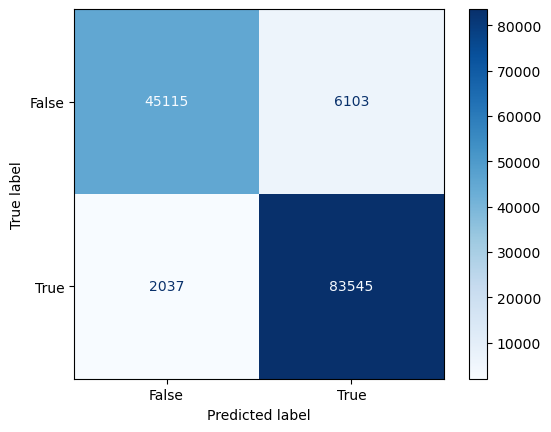

In [147]:
show_results(clf_lgb, X_train, y_train, X_test, y_test)

### Naive Bayes

In [58]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB

In [59]:
%%time
clf_nb = BernoulliNB()
clf_nb.fit(X_train_scaled, y_train)

CPU times: user 125 ms, sys: 61.5 ms, total: 186 ms
Wall time: 173 ms


BernoulliNB()

0.7100594400834883


Accuracy,Accuracy (Train),F1-Score
0.813158,0.812462,0.862169


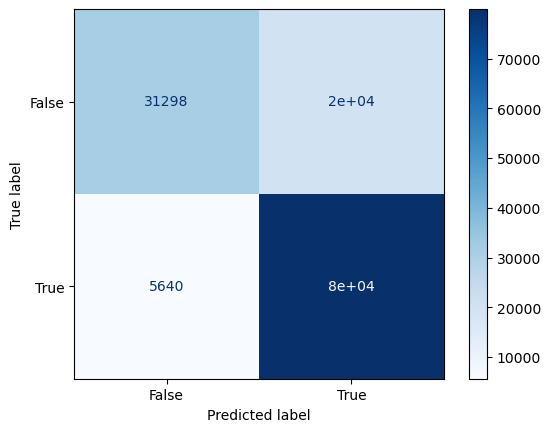

In [156]:
show_results(clf_nb, X_train_scaled, y_train, X_test_scaled, y_test)

### KNN

In [ ]:
def objective(trial):
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 3, 300),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'p': trial.suggest_int('p', 1, 5)
    }
    model = KNeighborsClassifier(**params, n_jobs=-1)
    
    #Training the model on the training data
    score = cross_val_score(model, X_train_scaled, y_train, cv=5)
    accuracy = score.mean()
    return accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20, n_jobs=-1)
print(study.best_trial)

In [183]:
clf_knn = KNeighborsClassifier(n_neighbors=39, weights='distance', n_jobs=-1)
clf_knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=39, weights='distance')

Accuracy,Accuracy (Train),F1-Score
0.933860,0.965380,0.948266


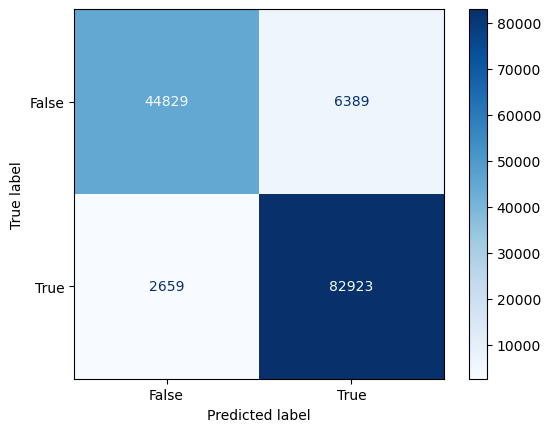

CPU times: user 29min 1s, sys: 292 ms, total: 29min 1s
Wall time: 3min 39s


In [80]:
%%time
show_results(clf_knn, X_train_scaled, y_train, X_test_scaled, y_test)

### Ensemble

In [60]:
classifiers = [
#    Pipeline([
#        ('scale', scaler),
#        ('clf', clf_knn)
#    ]),
    Pipeline([
        ('scale', scaler),
        ('clf', clf_nb)
    ]),
    rf,
    clf_xgb,
    clf_lgb,
]

In [64]:
def objective(trial):
    weights=[0, 0, 0, 0]
    for i in range(len(weights)):
        weights[i] = trial.suggest_int(f"W{i}", 1, 6)
    model =EnsembleVoteClassifier(clfs=classifiers, weights=weights, voting='soft', fit_base_estimators=False, use_clones=False)
    model.fit(None,np.array([0, 1]))
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20, n_jobs=-1)
print(study.best_trial)

[I 2023-11-02 02:17:35,872] A new study created in memory with name: no-name-431436c6-a5bc-488b-af87-c97ec370e018
/home/aleradamantis/miniconda3/envs/TFM/lib/python3.10/site-packages/mlxtend/classifier/ensemble_vote.py:172: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn(
/home/aleradamantis/miniconda3/envs/TFM/lib/python3.10/site-packages/mlxtend/classifier/ensemble_vote.py:172: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn(
/home/aleradamantis/miniconda3/envs/TFM/lib/python3.10/site-packages/mlxtend/classifier/ensemble_vote.py:172: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn(
/home/aleradamantis/miniconda3/envs/TFM/lib/python3.10/site-packages/mlxtend/classifier/ensemble_vote.py:172: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn(
/home/aleradamantis/miniconda3/envs/TFM/lib/python3.10/site-packages/mlxtend/classifie

[LightGBM] [Warning] feature_fraction is set=0.948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.948
[LightGBM] [Warning] lambda_l2 is set=0.0034181574651184544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0034181574651184544
[LightGBM] [Warning] lambda_l1 is set=0.00014051630697521031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014051630697521031
[LightGBM] [Warning] bagging_fraction is set=0.9589889729015272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9589889729015272
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.948
[LightGBM] [Warning] lambda_l2 is set=0.0034181574651184544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0034181574651184544
[LightGBM] [Warning] lambda_l1 is set=0.00014051630697521031, reg_al

[I 2023-11-02 02:18:29,044] Trial 10 finished with value: 0.9382090643274854 and parameters: {'W0': 4, 'W1': 6, 'W2': 3, 'W3': 2}. Best is trial 10 with value: 0.9382090643274854.
/home/aleradamantis/miniconda3/envs/TFM/lib/python3.10/site-packages/mlxtend/classifier/ensemble_vote.py:172: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.948
[LightGBM] [Warning] lambda_l2 is set=0.0034181574651184544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0034181574651184544
[LightGBM] [Warning] lambda_l1 is set=0.00014051630697521031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014051630697521031
[LightGBM] [Warning] bagging_fraction is set=0.9589889729015272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9589889729015272
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.948
[LightGBM] [Warning] lambda_l2 is set=0.0034181574651184544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0034181574651184544
[LightGBM] [Warning] lambda_l1 is set=0.00014051630697521031, reg_al

[I 2023-11-02 02:18:34,692] Trial 3 finished with value: 0.9385891812865497 and parameters: {'W0': 3, 'W1': 3, 'W2': 4, 'W3': 2}. Best is trial 3 with value: 0.9385891812865497.


[LightGBM] [Warning] feature_fraction is set=0.948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.948
[LightGBM] [Warning] lambda_l2 is set=0.0034181574651184544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0034181574651184544
[LightGBM] [Warning] lambda_l1 is set=0.00014051630697521031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014051630697521031
[LightGBM] [Warning] bagging_fraction is set=0.9589889729015272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9589889729015272
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.948
[LightGBM] [Warning] lambda_l2 is set=0.0034181574651184544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0034181574651184544
[LightGBM] [Warning] lambda_l1 is set=0.00014051630697521031, reg_al

/home/aleradamantis/miniconda3/envs/TFM/lib/python3.10/site-packages/mlxtend/classifier/ensemble_vote.py:172: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.948
[LightGBM] [Warning] lambda_l2 is set=0.0034181574651184544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0034181574651184544
[LightGBM] [Warning] lambda_l1 is set=0.00014051630697521031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014051630697521031
[LightGBM] [Warning] bagging_fraction is set=0.9589889729015272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9589889729015272
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.948
[LightGBM] [Warning] lambda_l2 is set=0.0034181574651184544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0034181574651184544
[LightGBM] [Warning] lambda_l1 is set=0.00014051630697521031, reg_al

[I 2023-11-02 02:18:42,466] Trial 6 finished with value: 0.9406652046783626 and parameters: {'W0': 1, 'W1': 5, 'W2': 2, 'W3': 3}. Best is trial 6 with value: 0.9406652046783626.
/home/aleradamantis/miniconda3/envs/TFM/lib/python3.10/site-packages/mlxtend/classifier/ensemble_vote.py:172: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn(
[I 2023-11-02 02:18:44,526] Trial 13 finished with value: 0.938969298245614 and parameters: {'W0': 3, 'W1': 2, 'W2': 6, 'W3': 2}. Best is trial 6 with value: 0.9406652046783626.
/home/aleradamantis/miniconda3/envs/TFM/lib/python3.10/site-packages/mlxtend/classifier/ensemble_vote.py:172: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn(
[I 2023-11-02 02:18:45,750] Trial 12 finished with value: 0.940248538011696 and parameters: {'W0': 3, 'W1': 4, 'W2': 2, 'W3': 6}. Best is trial 6 with value: 0.9406652046783626.
[I 2023-11-02 02:18:45,830] Trial 1 finished with value: 0.9371710

[LightGBM] [Warning] feature_fraction is set=0.948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.948
[LightGBM] [Warning] lambda_l2 is set=0.0034181574651184544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0034181574651184544
[LightGBM] [Warning] lambda_l1 is set=0.00014051630697521031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014051630697521031
[LightGBM] [Warning] bagging_fraction is set=0.9589889729015272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9589889729015272
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-11-02 02:18:54,713] Trial 16 finished with value: 0.9391228070175439 and parameters: {'W0': 5, 'W1': 5, 'W2': 4, 'W3': 6}. Best is trial 6 with value: 0.9406652046783626.


[LightGBM] [Warning] feature_fraction is set=0.948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.948
[LightGBM] [Warning] lambda_l2 is set=0.0034181574651184544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0034181574651184544
[LightGBM] [Warning] lambda_l1 is set=0.00014051630697521031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014051630697521031
[LightGBM] [Warning] bagging_fraction is set=0.9589889729015272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9589889729015272
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-11-02 02:18:57,852] Trial 17 finished with value: 0.9367251461988304 and parameters: {'W0': 6, 'W1': 6, 'W2': 5, 'W3': 2}. Best is trial 6 with value: 0.9406652046783626.


[LightGBM] [Warning] feature_fraction is set=0.948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.948
[LightGBM] [Warning] lambda_l2 is set=0.0034181574651184544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0034181574651184544
[LightGBM] [Warning] lambda_l1 is set=0.00014051630697521031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014051630697521031
[LightGBM] [Warning] bagging_fraction is set=0.9589889729015272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9589889729015272
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.948
[LightGBM] [Warning] lambda_l2 is set=0.0034181574651184544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0034181574651184544
[LightGBM] [Warning] lambda_l1 is set=0.00014051630697521031, reg_al

[I 2023-11-02 02:19:00,809] Trial 18 finished with value: 0.9333991228070175 and parameters: {'W0': 5, 'W1': 1, 'W2': 3, 'W3': 3}. Best is trial 6 with value: 0.9406652046783626.
[I 2023-11-02 02:19:01,007] Trial 19 finished with value: 0.8629239766081871 and parameters: {'W0': 5, 'W1': 1, 'W2': 1, 'W3': 1}. Best is trial 6 with value: 0.9406652046783626.


FrozenTrial(number=6, state=TrialState.COMPLETE, values=[0.9406652046783626], datetime_start=datetime.datetime(2023, 11, 2, 2, 17, 35, 883428), datetime_complete=datetime.datetime(2023, 11, 2, 2, 18, 42, 465987), params={'W0': 1, 'W1': 5, 'W2': 2, 'W3': 3}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'W0': IntDistribution(high=6, log=False, low=1, step=1), 'W1': IntDistribution(high=6, log=False, low=1, step=1), 'W2': IntDistribution(high=6, log=False, low=1, step=1), 'W3': IntDistribution(high=6, log=False, low=1, step=1)}, trial_id=6, value=None)


In [67]:
eclf = EnsembleVoteClassifier(clfs=classifiers, weights=[1, 5, 2, 3], fit_base_estimators=False, use_clones=False, voting='soft',) #with KNN [1, 1,3,4,6], #without KNN hard 94.06%
eclf.fit(None,np.array([0, 1]))
 

EnsembleVoteClassifier(clfs=[Pipeline(steps=[('scale', StandardScaler()),
                                             ('clf', BernoulliNB())]),
                             RandomForestClassifier(max_depth=56,
                                                    max_features=0.5974319440504214,
                                                    min_samples_split=18,
                                                    n_estimators=1500,
                                                    n_jobs=-1),
                             XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=0.75676022067519...
                                           predictor=None, random_state=None, ...),
                             LGBMClassifier(bagging_fraction=0.9589889729015272,
                                            bagging_freq=2,
                                            feature_fraction=0.948,
                                            feature_pre_filter=False,
                                            lambda_l1=0.00014051630697521031,
                                            lambda_l2=0.0034181574651184544,
                                            metric='binary_logloss',
                                            n_estimators=1000, num_leaves=255,
                                            num_threads=16,
                                            objective='binary')],
                       fit_base_estimators=False, use_clones=False,
                       voting='soft', weights=[1, 5, 2, 3])

[LightGBM] [Warning] feature_fraction is set=0.948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.948
[LightGBM] [Warning] lambda_l2 is set=0.0034181574651184544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0034181574651184544
[LightGBM] [Warning] lambda_l1 is set=0.00014051630697521031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014051630697521031
[LightGBM] [Warning] bagging_fraction is set=0.9589889729015272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9589889729015272
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.948
[LightGBM] [Warning] lambda_l2 is set=0.0034181574651184544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0034181574651184544
[LightGBM] [Warning] lambda_l1 is set=0.00014051630697521031, reg_al

Accuracy,Accuracy (Train),F1-Score
0.940665,0.953212,0.953917


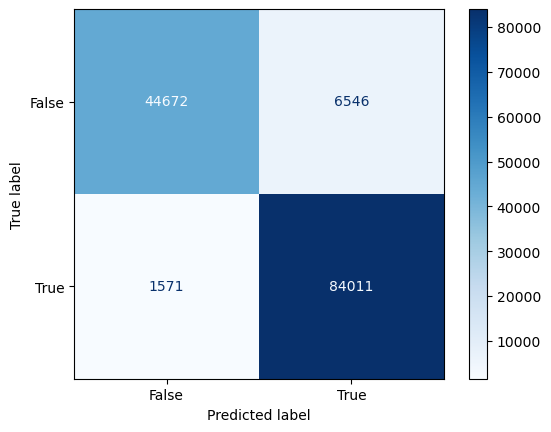

In [68]:
show_results(eclf, X_train, y_train, X_test, y_test)

## NLP

In [83]:
#https://medium.com/sfu-cspmp/detecting-malicious-urls-2412091872d6
import nltk
from nltk.tokenize import word_tokenize
import string
import itertools
from sklearn.linear_model import SGDClassifier, PassiveAggressiveClassifier
from nltk.util import ngrams
from sklearn.naive_bayes import MultinomialNB
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

ModuleNotFoundError: No module named 'nltk'

### Using Scikit-Learn Vectorizers

Different tests:
- Count VS Tfidf VS Hash Vectorizer
- Different classifiers
- char vs word analyzer
- different range of ngrams
- When in char analyzer, removing symbols (df['url'].str.replace('\W+', '', regex=True)) (seems to do worse)
- Minibatching VS Complete train
- Ensemble

### TF-IDF Vectorizer

In [84]:
vectorizerTFIDF = TfidfVectorizer(analyzer='char', ngram_range=(3,3), lowercase=False) #4,4 is the best, but not worth the time (0.958)
y = df['is_benign']
X = vectorizerTFIDF.fit_transform(df['url'])

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 99)


### Random Forest

In [ ]:
%%time
params={
    'n_estimators': 500, 
    'max_features': 0.5974319440504214, 
    'max_depth': 56, 
    'min_samples_split': 18, 
    'min_samples_leaf': 1,
    'n_jobs':-1
}
rf = RandomForestClassifier(n_estimators=500,n_jobs=-1)
rf.fit(X_train, y_train)

0.9390294992183269


Accuracy,Accuracy (Train),F1-Score
0.956382,0.999843,0.966045


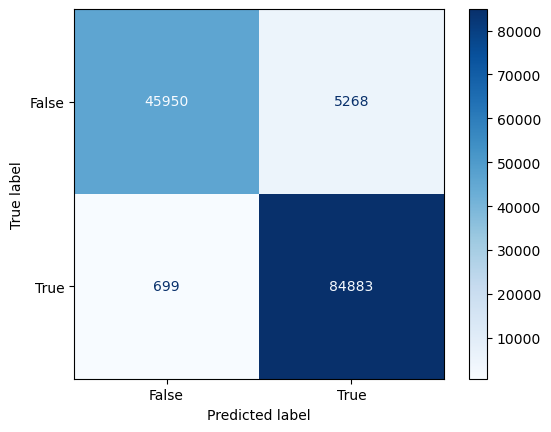

In [70]:
show_results(rf, X_train, y_train, X_test, y_test)

### XGBoost

In [ ]:
%%time
params = {
    "objective": 'binary:logistic',
    "device": "cuda",
    "n_estimators": 500,
    'learning_rate': 0.09043995153685692, 
    'max_depth': 10, 
    'subsample': 0.38021996618039755, 
    'colsample_bytree': 0.8337519527736863, 
    'min_child_weight': 14,
    'n_jobs':-1,
    "silent": 1
}

clf_xgb = xgb.XGBClassifier(**params, verbosity=0,verbose_eval= 0,)

#Training the model on the training data
clf_xgb.fit(X_train, y_train)

0.9335490394337714


Accuracy,Accuracy (Train),F1-Score
0.951959,0.955702,0.962381


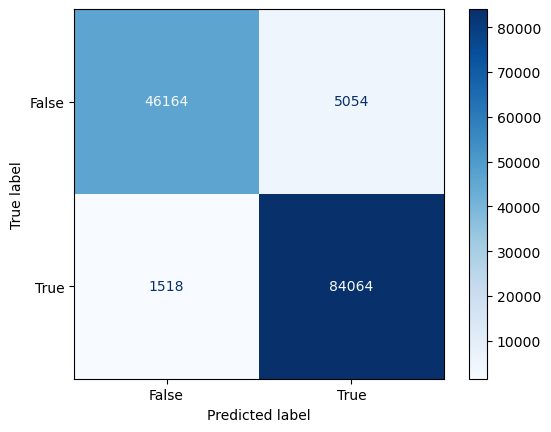

In [72]:
show_results(clf_xgb, X_train, y_train, X_test, y_test)

### Light GBM

In [ ]:
import optuna.integration.lightgbm as lgb_opt

from lightgbm import early_stopping
from lightgbm import log_evaluation
from sklearn.model_selection import KFold


if __name__ == "__main__":
    dtrain = lgb_opt.Dataset(X_train, label=y_train)

    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
    }

    tuner = lgb_opt.LightGBMTunerCV(
        params,
        dtrain,
        folds=KFold(n_splits=3),
        callbacks=[early_stopping(100), log_evaluation(100)],
    )

    tuner.run()

    print("Best score:", tuner.best_score)
    best_params = tuner.best_params
    print("Best params:", best_params)
    print("  Params: ")
    for key, value in best_params.items():
        print("    {}: {}".format(key, value))

[I 2023-10-31 21:27:10,774] A new study created in memory with name: no-name-c86eb489-08be-4e2a-b24b-70f1dcbc5687
feature_fraction, val_score: inf:   0%|                                                           | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.170931 + 0.00058512
[200]	cv_agg's valid binary_logloss: 0.141911 + 0.000647634
[300]	cv_agg's valid binary_logloss: 0.127768 + 0.00057803
[400]	cv_agg's valid binary_logloss: 0.119087 + 0.000451388
[500]	cv_agg's valid binary_logloss: 0.113266 + 0.000556028
[600]	cv_agg's valid binary_logloss: 0.108754 + 0.000500717
[700]	cv_agg's valid binary_logloss: 0.105249 + 0.000539594
[800]	cv_agg's valid binary_logloss: 0.102472 + 0.000548695
[900]	cv_agg's valid binary_logloss: 0.100207 + 0.00057562
[1000]	cv_agg's valid binary_logloss: 0.0982016 + 0.000470791
Did not meet early stopping. Best iteration is:
[1000]	cv_agg's valid binary_logloss: 0.0982016 + 0.000470791


feature_fraction, val_score: 0.098202:  14%|######                                    | 1/7 [17:12<1:43:14, 1032.44s/it]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.172753 + 0.00076212
[200]	cv_agg's valid binary_logloss: 0.143668 + 0.000630454
[300]	cv_agg's valid binary_logloss: 0.129454 + 0.000667494
[400]	cv_agg's valid binary_logloss: 0.120782 + 0.000663204
[500]	cv_agg's valid binary_logloss: 0.114802 + 0.000642431
[600]	cv_agg's valid binary_logloss: 0.110253 + 0.000662808
[700]	cv_agg's valid binary_logloss: 0.106816 + 0.000591245
[800]	cv_agg's valid binary_logloss: 0.10394 + 0.000619688
[900]	cv_agg's valid binary_logloss: 0.101671 + 0.000656188
[1000]	cv_agg's valid binary_logloss: 0.0996567 + 0.000639241
Did not meet early stopping. Best iteration is:
[1000]	cv_agg's valid binary_logloss: 0.0996567 + 0.000639241


feature_fraction, val_score: 0.098202:  29%|############                              | 2/7 [53:34<2:22:23, 1708.74s/it]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.171961 + 0.000686125
[200]	cv_agg's valid binary_logloss: 0.1427 + 0.0006753
[300]	cv_agg's valid binary_logloss: 0.128622 + 0.000570025
[400]	cv_agg's valid binary_logloss: 0.119914 + 0.000496254
[500]	cv_agg's valid binary_logloss: 0.113907 + 0.000479069
[600]	cv_agg's valid binary_logloss: 0.10944 + 0.000427529
[700]	cv_agg's valid binary_logloss: 0.106051 + 0.000381188
[800]	cv_agg's valid binary_logloss: 0.103188 + 0.000420384
[900]	cv_agg's valid binary_logloss: 0.100837 + 0.000425525
[1000]	cv_agg's valid binary_logloss: 0.0988641 + 0.000405472
Did not meet early stopping. Best iteration is:
[1000]	cv_agg's valid binary_logloss: 0.0988641 + 0.000405472


feature_fraction, val_score: 0.098202:  43%|#################1                      | 3/7 [1:10:08<1:32:08, 1382.14s/it]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.171623 + 0.000488962
[200]	cv_agg's valid binary_logloss: 0.142357 + 0.000565016
[300]	cv_agg's valid binary_logloss: 0.128306 + 0.000440831
[400]	cv_agg's valid binary_logloss: 0.119829 + 0.000488792
[500]	cv_agg's valid binary_logloss: 0.113646 + 0.000597993
[600]	cv_agg's valid binary_logloss: 0.109216 + 0.000543097
[700]	cv_agg's valid binary_logloss: 0.105764 + 0.000522639
[800]	cv_agg's valid binary_logloss: 0.103007 + 0.000512048
[900]	cv_agg's valid binary_logloss: 0.100736 + 0.00048386
[1000]	cv_agg's valid binary_logloss: 0.0987763 + 0.000569658
Did not meet early stopping. Best iteration is:
[1000]	cv_agg's valid binary_logloss: 0.0987763 + 0.000569658


feature_fraction, val_score: 0.098202:  57%|######################8                 | 4/7 [1:26:44<1:01:29, 1229.74s/it]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.174099 + 0.000438462
[200]	cv_agg's valid binary_logloss: 0.144566 + 0.000580442
[300]	cv_agg's valid binary_logloss: 0.130334 + 0.000578232
[400]	cv_agg's valid binary_logloss: 0.121542 + 0.000505274
[500]	cv_agg's valid binary_logloss: 0.115506 + 0.000590809
[600]	cv_agg's valid binary_logloss: 0.110976 + 0.000570165
[700]	cv_agg's valid binary_logloss: 0.107386 + 0.000520393
[800]	cv_agg's valid binary_logloss: 0.104521 + 0.000555355
[900]	cv_agg's valid binary_logloss: 0.102173 + 0.000555032
[1000]	cv_agg's valid binary_logloss: 0.100235 + 0.000567823
Did not meet early stopping. Best iteration is:
[1000]	cv_agg's valid binary_logloss: 0.100235 + 0.000567823


feature_fraction, val_score: 0.098202:  71%|##############################            | 5/7 [1:56:33<47:42, 1431.37s/it]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.170847 + 0.000565315
[200]	cv_agg's valid binary_logloss: 0.141991 + 0.000524411
[300]	cv_agg's valid binary_logloss: 0.127955 + 0.000571348
[400]	cv_agg's valid binary_logloss: 0.119311 + 0.000450434
[500]	cv_agg's valid binary_logloss: 0.113371 + 0.000562216
[600]	cv_agg's valid binary_logloss: 0.108892 + 0.000613837
[700]	cv_agg's valid binary_logloss: 0.105507 + 0.000434092
[800]	cv_agg's valid binary_logloss: 0.102772 + 0.000491433
[900]	cv_agg's valid binary_logloss: 0.100434 + 0.00049965
[1000]	cv_agg's valid binary_logloss: 0.0984286 + 0.000480891
Did not meet early stopping. Best iteration is:
[1000]	cv_agg's valid binary_logloss: 0.0984286 + 0.000480891


feature_fraction, val_score: 0.098202:  86%|####################################      | 6/7 [2:12:55<21:18, 1278.57s/it]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.172126 + 0.000868979
[200]	cv_agg's valid binary_logloss: 0.143303 + 0.000751219
[300]	cv_agg's valid binary_logloss: 0.129072 + 0.000641247
[400]	cv_agg's valid binary_logloss: 0.12049 + 0.000726674
[500]	cv_agg's valid binary_logloss: 0.114383 + 0.000654047
[600]	cv_agg's valid binary_logloss: 0.109941 + 0.00060971
[700]	cv_agg's valid binary_logloss: 0.106407 + 0.000592798
[800]	cv_agg's valid binary_logloss: 0.103587 + 0.000524193
[900]	cv_agg's valid binary_logloss: 0.101301 + 0.000426105
[1000]	cv_agg's valid binary_logloss: 0.099249 + 0.000414627
Did not meet early stopping. Best iteration is:
[1000]	cv_agg's valid binary_logloss: 0.099249 + 0.000414627


num_leaves, val_score: 0.098202:   0%|                                                           | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.123746 + 0.000612359
[200]	cv_agg's valid binary_logloss: 0.104034 + 0.000312687
[300]	cv_agg's valid binary_logloss: 0.095976 + 0.000342632
[400]	cv_agg's valid binary_logloss: 0.0913294 + 0.000344024
[500]	cv_agg's valid binary_logloss: 0.0883642 + 0.000437311
[600]	cv_agg's valid binary_logloss: 0.0862307 + 0.000403726
[700]	cv_agg's valid binary_logloss: 0.0846786 + 0.000365641
[800]	cv_agg's valid binary_logloss: 0.0836442 + 0.000410451
[900]	cv_agg's valid binary_logloss: 0.0829751 + 0.000364454
[1000]	cv_agg's valid binary_logloss: 0.082588 + 0.000349086
Did not meet early stopping. Best iteration is:
[1000]	cv_agg's valid binary_logloss: 0.082588 + 0.000349086


num_leaves, val_score: 0.082588:   5%|##3                                           | 1/20 [35:24<11:12:32, 2123.80s/it]

In [30]:
%%time
import lightgbm as lgb
# build the lightgbm model
params={
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'feature_pre_filter': False,
    'lambda_l1': 0.00014051630697521031,
    'lambda_l2': 0.0034181574651184544,
    'num_leaves': 103,
    'feature_fraction': 0.648,
    'bagging_fraction': 0.9589889729015272,
    'bagging_freq': 2,
    'min_child_samples': 20,
}
clf_lgb = lgb.LGBMClassifier(objective='binary', metric='binary_logloss', boosting_type='gbdt', feature_pre_filter=False, lambda_l1=0.00014051630697521031, lambda_l2=0.0034181574651184544, num_leaves=255, feature_fraction=0.948, bagging_fraction=0.9589889729015272, bagging_freq=2, min_child_samples=20,  n_estimators=1000, num_threads=16,)# best n_estimators=1000, num_leaves=100,
clf_lgb.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.948
[LightGBM] [Warning] lambda_l2 is set=0.0034181574651184544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0034181574651184544
[LightGBM] [Warning] lambda_l1 is set=0.00014051630697521031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014051630697521031
[LightGBM] [Warning] bagging_fraction is set=0.9589889729015272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9589889729015272
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.948
[LightGBM] [Warning] lambda_l2 is set=0.0034181574651184544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0034181574651184544
[LightGBM] [Warning] lambda_l1 is set=0.00014051630697521031, reg_al

LGBMClassifier(bagging_fraction=0.9589889729015272, bagging_freq=2,
               feature_fraction=0.948, feature_pre_filter=False,
               lambda_l1=0.00014051630697521031,
               lambda_l2=0.0034181574651184544, metric='binary_logloss',
               n_estimators=1000, num_leaves=255, num_threads=16,
               objective='binary')

### Count Vectorizer

In [ ]:
vectorizerCount = CountVectorizer(ngram_range=(1,2))
y = df['is_benign']
X = vectorizerCount.fit_transform(df['url'])

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 99)

In [ ]:
X.shape[1]

### Multinomial NB

In [ ]:
%%time
clf_nb = MultinomialNB(alpha=1)
clf_nb.fit(X_train, y_train)

0.9055905145377658


Accuracy,Accuracy (Train),F1-Score
0.931784,0.980137,0.946599


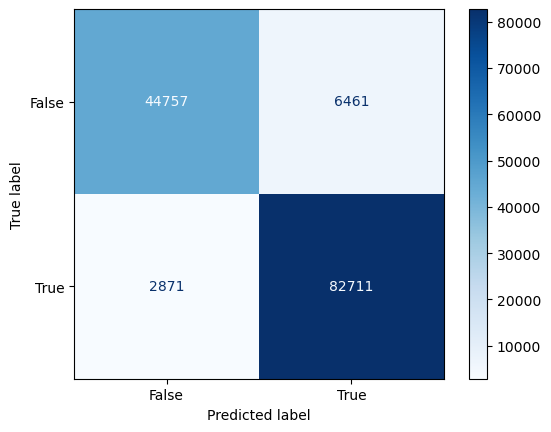

In [76]:
show_results(clf_nb, X_train, y_train, X_test, y_test)

### SGD Classifier

In [ ]:
%%time
clf_sgd = SGDClassifier(alpha=0.00001, class_weight='balanced')
clf_sgd.fit(X_train, y_train)

In [ ]:
show_results(clf_sgd, X_train, y_train, X_test, y_test)

In [ ]:
clf_CC = CalibratedClassifierCV(clf_sgd).fit(X_train, y_train)

In [ ]:
show_results(clf_CC, X_train, y_train, X_test, y_test)

### Ensemble

In [ ]:
y = df['is_benign']
X = df['url']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 99)

In [ ]:
classifiers = [
    Pipeline([
        ('vectorizer', vectorizerTFIDF),
        ('clf', rf)
    ]),
    Pipeline([
        ('vectorizer', vectorizerTFIDF),
        ('clf', clf_xgb)
    ]),
    Pipeline([
        ('vectorizer', vectorizerCount),
        ('clf', clf_nb)
    ]),
    Pipeline([
        ('vectorizer', vectorizerCount),
        ('clf', clf_CC)
    ]),
]

In [ ]:
def objective(trial):
    weights=[0, 0, 0, 0]
    for i in range(len(weights)):
        weights[i] = trial.suggest_int(f"W{i}", 1, 6)
    model =EnsembleVoteClassifier(clfs=classifiers, weights=weights, fit_base_estimators=False, use_clones=False, voting='soft')
    model.fit(None,np.array([0, 1]))
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20, n_jobs=-1)
print(study.best_trial)

In [44]:
eclf = EnsembleVoteClassifier(clfs=classifiers, weights=[1, 5, 2, 4], fit_base_estimators=False, use_clones=False, voting='soft') #with KNN [1, 1,3,4,6]
eclf.fit(None,np.array([0, 1]))

EnsembleVoteClassifier(clfs=[Pipeline(steps=[('vectorizer',
                                              TfidfVectorizer(analyzer='char',
                                                              lowercase=False,
                                                              ngram_range=(3,
                                                                           3))),
                                             ('clf',
                                              RandomForestClassifier(n_estimators=500,
                                                                     n_jobs=-1))]),
                             Pipeline(steps=[('vectorizer',
                                              TfidfVectorizer(analyzer='char',
                                                              lowercase=False,
                                                              ngram_range=(3,
                                                                           3))),
                                             ('clf',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None...
                                                            predictor=None, ...))]),
                             Pipeline(steps=[('vectorizer',
                                              CountVectorizer(ngram_range=(1,
                                                                           2))),
                                             ('clf', MultinomialNB(alpha=1))]),
                             Pipeline(steps=[('vectorizer',
                                              CountVectorizer(ngram_range=(1,
                                                                           2))),
                                             ('clf',
                                              CalibratedClassifierCV(estimator=SGDClassifier(alpha=1e-05,
                                                                                             class_weight='balanced')))])],
                       fit_base_estimators=False, use_clones=False,
                       voting='soft', weights=[1, 5, 2, 4])

In [188]:
eclf.score(X_test, y_test)

0.966798245614035

In [ ]:
import shap
explainer = shap.KernelExplainer(clf_sgd.predict, X_test)
shap_values = explainer.shap_values(X_test)


In [55]:
import joblib

In [56]:
# Serialize the ensemble model to a file
filename = 'voting_ensemble_model.sav'
joblib.dump(ensemble, filename)

NameError: name 'ensemble' is not defined

In [ ]:
# To deserialize and use the model later
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test, y_test)

0.954500870748844


Accuracy,Accuracy (Train),F1-Score
0.966769,0.992372,0.973826


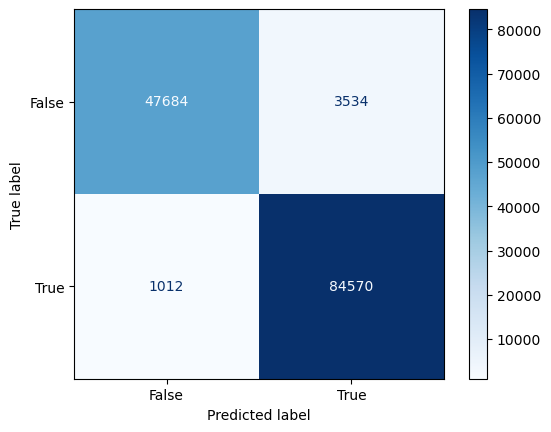

In [49]:
show_results(eclf, X_train, y_train, X_test, y_test)

### Hashing Vectorizer

In [119]:
vectorizer = HashingVectorizer(ngram_range=(1,2)) #limiting features 500k, -0.2% accuracy but half the features
y = df['is_benign']
X = vectorizer.fit_transform(df['url'])

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 99)

In [120]:
X.shape

(683997, 1048576)

In [121]:
%%time
clf_sgd = SGDClassifier(alpha=0.00001, random_state=99, class_weight='balanced')
clf_sgd.fit(X_train, y_train)

CPU times: user 1.22 s, sys: 840 ms, total: 2.06 s
Wall time: 888 ms


SGDClassifier(alpha=1e-05, class_weight='balanced', random_state=99)

Accuracy,F1-Score
0.930775,0.946369


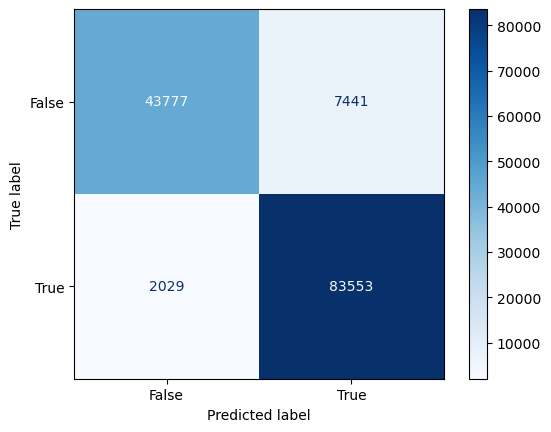

In [110]:
show_results(clf_sgd, X_train, y_train, X_test, y_test)

## Multiclass Classification

In [123]:
from sklearn.preprocessing import LabelEncoder

df_m = df.drop('is_benign',axis=1)
le = LabelEncoder()
df_m['type'] = le.fit_transform(df_m["type"])


### Feature engineering

In [152]:
df_n = pd.get_dummies(df_m.select_dtypes(include=['number']).astype('float32').join(df_m[['tld_cat']]), columns=['tld_cat']) 

In [153]:
feature_names = df_n.drop('type',axis=1).columns

In [154]:
y = df_n[['type']].values.ravel()
X = df_n.drop('type',axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 99)

In [136]:
%%time
import lightgbm as lgb
# build the lightgbm model

clf_lgb = lgb.LGBMClassifier(boosting_type='gbdt', feature_pre_filter=False, lambda_l1=0.00014051630697521031, lambda_l2=0.0034181574651184544, num_leaves=255, feature_fraction=0.948, bagging_fraction=0.9589889729015272, bagging_freq=2, min_child_samples=20,  n_estimators=1000, num_threads=16,)# best n_estimators=1000, num_leaves=100,
clf_lgb.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.948
[LightGBM] [Warning] lambda_l2 is set=0.0034181574651184544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0034181574651184544
[LightGBM] [Warning] lambda_l1 is set=0.00014051630697521031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014051630697521031
[LightGBM] [Warning] bagging_fraction is set=0.9589889729015272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9589889729015272
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.948
[LightGBM] [Warning] lambda_l2 is set=0.0034181574651184544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0034181574651184544
[LightGBM] [Warning] lambda_l1 is set=0.00014051630697521031, reg_al

LGBMClassifier(bagging_fraction=0.9589889729015272, bagging_freq=2,
               feature_fraction=0.948, feature_pre_filter=False,
               lambda_l1=0.00014051630697521031,
               lambda_l2=0.0034181574651184544, n_estimators=1000,
               num_leaves=255, num_threads=16)

In [155]:
y_pred = clf_lgb.predict(X_test)

[LightGBM] [Warning] feature_fraction is set=0.948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.948
[LightGBM] [Warning] lambda_l2 is set=0.0034181574651184544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0034181574651184544
[LightGBM] [Warning] lambda_l1 is set=0.00014051630697521031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014051630697521031
[LightGBM] [Warning] bagging_fraction is set=0.9589889729015272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9589889729015272
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


In [156]:
print(classification_report(y_test, y_pred, target_names=le.classes_, digits=4),)

              precision    recall  f1-score   support

      benign     0.9319    0.9743    0.9526     85582
  defacement     0.9657    0.9843    0.9749     18828
     malware     0.9689    0.9309    0.9495     13434
    phishing     0.8325    0.6685    0.7416     18956

    accuracy                         0.9291    136800
   macro avg     0.9247    0.8895    0.9047    136800
weighted avg     0.9264    0.9291    0.9261    136800



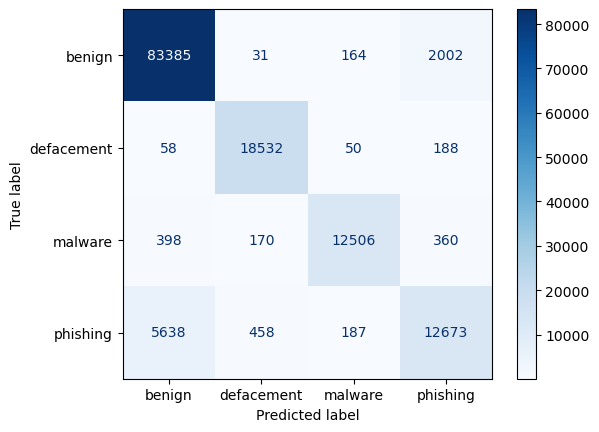

In [139]:
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = le.classes_)
cm_display.plot(cmap='Blues')

### NLP

#### Count

In [124]:
vectorizerCount = CountVectorizer(ngram_range=(1,3))

y = df_m["type"]
X = vectorizerCount.fit_transform(df_m['url'])

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 99)

In [125]:
%%time
clf_sgd = SGDClassifier(alpha=0.00001, class_weight='balanced')
clf_sgd.fit(X_train, y_train)

CPU times: user 8.68 s, sys: 3.79 s, total: 12.5 s
Wall time: 7.41 s


SGDClassifier(alpha=1e-05, class_weight='balanced')

              precision    recall  f1-score   support

      benign     0.9463    0.9814    0.9635     85582
  defacement     0.9971    0.9996    0.9983     18828
     malware     0.9946    0.9752    0.9848     13434
    phishing     0.8901    0.7513    0.8149     18956

    accuracy                         0.9514    136800
   macro avg     0.9570    0.9269    0.9404    136800
weighted avg     0.9503    0.9514    0.9498    136800



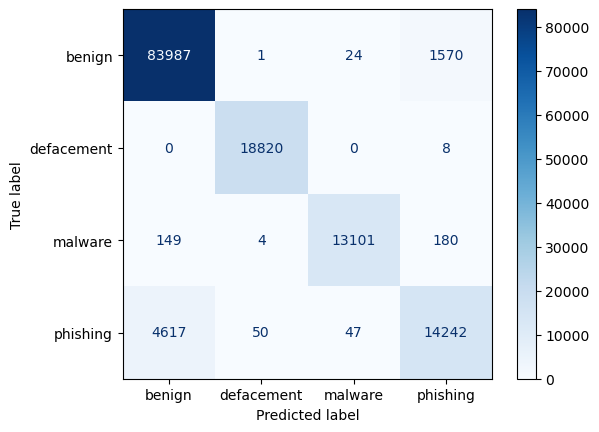

In [126]:
y_pred = clf_sgd.predict(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_, digits=4), )

cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = le.classes_)
cm_display.plot(cmap='Blues')

In [56]:
df[df['url']=='https://linkedin.com/pub/george-cleveland/7/80a/599']

,url,type,is_benign,is_https,url_len,tld,tld_len,tld_cat,url_parse_object,is_ip,non_ascii,n_domains,n_dirs,port,path_len,hostname_len,has_fragment,n_query_arguments,n_digits
56,https://linkedin.com/pub/george-cleveland/7/80...,benign,1,1,51,com,3,com,"(https, linkedin.com, /pub/george-cleveland/7/...",0,0,1,5,0,31,12,0,0,6


In [129]:
for i in X_test[0].nonzero()[1]:
    list(vectorizerCount.vocabulary_.keys())[list(vectorizerCount.vocabulary_.values()).index(i)]

In [141]:
df[df['url'].str.contains('myetlherwalle') & df['url'].str.contains('com')]['url']

215030    https://myetlherwalle.com
Name: url, dtype: object

In [131]:
n=0
keys =  list(vectorizerCount.vocabulary_.keys())
values = list(vectorizerCount.vocabulary_.values())
for row_index, (input, prediction, label) in enumerate(zip (X_test, le.inverse_transform(y_pred), le.inverse_transform(y_test))):
    if n >=5:
        break
    if label == 'phishing' and prediction != label:
        n+=1
        row=X_test[row_index].nonzero()[1]
        content = []
        for i in row:
            content.append(keys[values.index(i)])
            
        print('Row', content, 'has been classified as ', prediction, 'and should be ', label)

Row ['https', 'net', 'redwing', 'hutman', 'mreed', 'https redwing', 'redwing hutman', 'hutman net', 'net mreed', 'https redwing hutman', 'redwing hutman net', 'hutman net mreed'] has been classified as  benign and should be  phishing
Row ['https', 'com', 'html', 'acumen', 'tradewatch', 'haccp', 'https tradewatch', 'tradewatch com', 'com acumen', 'acumen haccp', 'haccp html', 'https tradewatch com', 'tradewatch com acumen', 'com acumen haccp', 'acumen haccp html'] has been classified as  benign and should be  phishing
Row ['https', 'com', 'en', 'us', 'social', 'forums', 'category', 'com forums', 'en us', 'microsoft', 'microsoft com', 'https social', 'forums en', 'microsoft com forums', 'com forums en', 'forums en us', 'technet', 'technet microsoft', 'technet microsoft com', 'social technet', 'https social technet', 'social technet microsoft', 'windowsvistaitpro', 'us category', 'category windowsvistaitpro', 'en us category', 'us category windowsvistaitpro'] has been classified as  benig

In [165]:
clf_CC = CalibratedClassifierCV(clf_sgd).fit(X_train, y_train)

              precision    recall  f1-score   support

      benign     0.9449    0.9821    0.9631     85582
  defacement     0.9981    0.9993    0.9987     18828
     malware     0.9949    0.9746    0.9847     13434
    phishing     0.8925    0.7454    0.8123     18956

    accuracy                         0.9510    136800
   macro avg     0.9576    0.9254    0.9397    136800
weighted avg     0.9498    0.9510    0.9492    136800



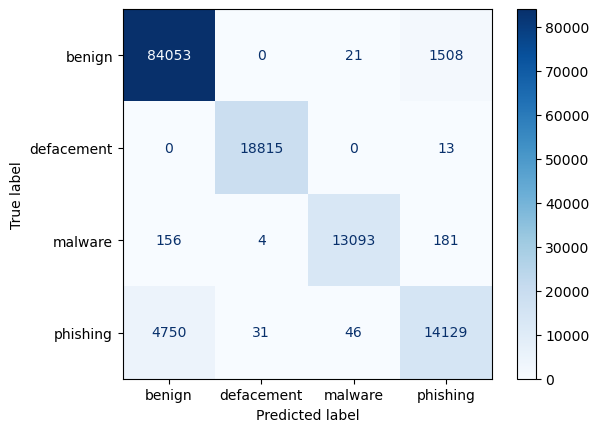

In [166]:
y_pred = clf_CC.predict(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_, digits=4), )

cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = le.classes_)
cm_display.plot(cmap='Blues')

#### TFIDF

In [161]:
vectorizerTFIDF = TfidfVectorizer(analyzer='char', ngram_range=(3,3), lowercase=False) #4,4 is the best, but not worth the time (0.958)

y = df_m["type"]
X = vectorizerTFIDF.fit_transform(df_m['url'])

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 99)

In [147]:
%%time
params = {
    "objective": 'multi:softmax',
    "device": "cuda",
    "n_estimators": 500,
    'learning_rate': 0.09043995153685692, 
    'max_depth': 10, 
    'subsample': 0.38021996618039755, 
    'colsample_bytree': 0.8337519527736863, 
    'min_child_weight': 14,
    'n_jobs':-1,
    "silent": 1
}

clf_xgb = xgb.XGBClassifier(**params, verbosity=0,verbose_eval= 0,)

#Training the model on the training data
clf_xgb.fit(X_train, y_train)

CPU times: user 4h 30min 37s, sys: 3.74 s, total: 4h 30min 41s
Wall time: 17min 47s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8337519527736863, device='cuda',
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.09043995153685692,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=14, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=-1, num_parallel_tree=None,
              objective='multi:softmax', ...)

In [162]:
y_pred = clf_xgb.predict(X_test)

In [163]:
print(classification_report(y_test, y_pred, target_names=le.classes_, digits=4), )

              precision    recall  f1-score   support

      benign     0.9447    0.9849    0.9644     85582
  defacement     0.9812    0.9948    0.9879     18828
     malware     0.9910    0.9531    0.9717     13434
    phishing     0.8966    0.7361    0.8085     18956

    accuracy                         0.9487    136800
   macro avg     0.9534    0.9172    0.9331    136800
weighted avg     0.9476    0.9487    0.9467    136800



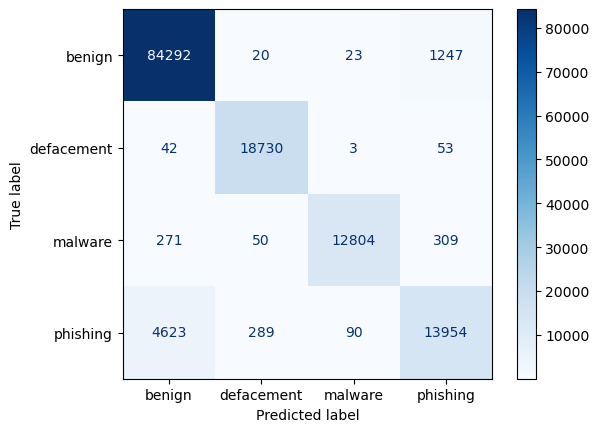

In [150]:
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = le.classes_)
cm_display.plot(cmap='Blues')